# NYC MoMA Artworks - Exploratory Analysis

<section id="toc">
    <h2>Introduction</h2>
</section>

<section id="toc">
    <h2>Table of Contents</h2>
    <ol>
        <li><a href="#intro">Introduction</a></li>
        <li><a href="#load-libaries">Load Libraries</a></li>
        <li><a href="#define-funcs">Defining Data Analysis Functions</a></li>
        <li><a href="#load-data">Load Data</a></li>
        <li><a href="#data-prep">Data Preprocessing</li>
        <li><a href="#data-valid">Data Validation</a></li>
        <li><a href="#desc-stats">Define Data Quality</a></li>
        <li><a href="#ts-analysis">Collections Time Series Analysis</li>
            <ul>
            <li><a href="#acc-and-ts">Time Series Analysis & Decomposition of Acquisition Count</a>
            </ul>
        <li><a href="#gap-analysis">Collections Spatial Analysis</a></li>
        <li><a href="#conclusions">Conclusions & Recommendations</a></li>
    </ol>
</section>

<section id="load-libaries">
    <h2>Load Libraries</h2> 
</section>

In [1]:
import warnings  # program error handling
import os  # file-handling
import pandas as pd  # data-manipulation
import numpy as np # data-manipulation
import seaborn as sns # data-visualization
from matplotlib import ticker  # data-visualization
import matplotlib.pyplot as plt # data-visualization
from etl import ensure_dataset_types  # data-type enforcement
import statsmodels.api as sm  # time series analysis: seasonal decomposition


sns.set_palette("colorblind")
pd.set_option("display.float_format", "{:0.3f}".format)
pd.set_option("display.max_rows", 100)
warnings.simplefilter(action = "ignore", category = Warning)

<section id="define-funcs">
    <h2>Data Analysis Functions</h2>
</section>

In [2]:
def counts_by(column_names: str|list[str], df):
    return df[column_names].value_counts()


def detect_IQR_outliers(dataset, lower = 0.25, upper = 0.75):
    """Detects values that lie outsides of the specified IQR range."""
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)
    outliers = dataset[~((lower_outliers > dataset) | (dataset < upper_outliers))]
    
    if not outliers.any().any():
        print("There are no outliers detected in the dataset.")
    else:
        print("Columns which contain outliers outside of the 25th and 75th percentiles:")
        print(outliers.any())
        return outliers


def remove_outliers(dataset, lower = 0.25, upper = 0.75):
    # Remove numerical outliers from the dataset
    dataset.astype(np.float64)
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)

    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def gen_ts_features(df, date_column, more_columns):
    """
    Generates Time Series Features based on `date_column`.
    Makes for easier analysis of operational (day-to-day) processes.
    """
    out = df[[date_column] + more_columns].copy()
    out[date_column] = pd.to_datetime(out[date_column], format = "%m/%d/%Y", errors = "coerce")
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    out["weekday"] = pd.Categorical(out[date_column].dt.day_name(), categories = weekday_order, ordered = True)
    out["day_of_month"] = out[date_column].dt.day.astype(int)
    out["day_of_year"] = out[date_column].dt.dayofyear.astype(int)
    out["week_of_month"] = (out[date_column].dt.day / 7).apply(lambda x: np.ceil(x)).astype(int)
    out["week"] = out[date_column].dt.isocalendar().week.astype(int)
    out["month"] = out[date_column].dt.month.astype(int)
    out["year"] = out[date_column].dt.isocalendar().year.astype(int)
    return out


def calculate_confidence_intervals_95(df: pd.DataFrame, column: str) -> tuple[float, float]:
    valid_data = df[~np.isnan(df[column])]
    # Calculate mean and 95% CI
    mean = valid_data[column].mean()
    std_err = valid_data[column].std() / np.sqrt(valid_data.shape[0])  # Standard error calculation
    lower_bound, upper_bound = (mean - 1.96 * std_err, mean + 1.96 * std_err)  # CI calculation
    return lower_bound, upper_bound

<section id="load-data">
    <h2>Load all data</h2>
</section>

In [3]:
# Load in Dataset(s)
file_path = os.path.join("./out/datasets", "NYC-MoMA-storage_group-fill.csv")
artworks_df = ensure_dataset_types(pd.read_csv(file_path, index_col=[0]))

<section id="#data-prep">
    <h2>Data Preprocessing</h2>
</section>

In [4]:
# Data Preprocessing
artworks_df = artworks_df.sort_values(by=["acquisition_date", "object_number"])

# Calculate the range for the last 30 years
latest_30_years = artworks_df["acquisition_date"].max() - pd.DateOffset(years=30)

# Final datasets for analysis
datasets = dict(
    artworks_data = artworks_df.copy(),
    recent_data = artworks_df[latest_30_years <= artworks_df["acquisition_date"]].copy()
)

datasets["artworks_tsdata"] = gen_ts_features(datasets["artworks_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "acq_total", "acq_gaps"])

datasets["recent_tsdata"] = gen_ts_features(datasets["recent_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "acq_total", "acq_gaps"])

# datasets["artworks_data"].loc[:, "acc_gaps"] = datasets["artworks_data"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["artworks_tsdata"].loc[:, "acc_gaps"] = datasets["artworks_tsdata"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["recent_data"].loc[:, "acc_gaps"] = datasets["recent_data"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["recent_data"].loc[:, "acc_gaps"] = datasets["recent_tsdata"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))

categorical_columns = datasets["artworks_data"].select_dtypes(include=["object", "category", "datetime64[ns]"]).columns
numerical_columns = datasets["artworks_data"].select_dtypes(exclude=["object", "category", "datetime64[ns]"]).columns
spatial_columns = [
    "height_ft",
    "width_ft",
    "depth_ft",
    "cubic_ft",
    "spatial_running_total",
]
# Point-of-Interest 
# Categorical columns which are most relevant for inventory analysis + forecasting
hue_categories = ["credit_group", "department",  "storage_group"]


<section id="data-valid">
    <h2>Data Validation</h2>
</section>

In [5]:
datasets["artworks_data"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 130262 entries, 55947 to 129943
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   126757 non-null  datetime64[ns]
 1   acquisition_date       130262 non-null  datetime64[ns]
 2   credit                 127192 non-null  object        
 3   department             130262 non-null  object        
 4   classification         130262 non-null  object        
 5   object_number          130262 non-null  object        
 6   credit_group           130262 non-null  object        
 7   storage_group          130262 non-null  object        
 8   height_ft              130262 non-null  float64       
 9   width_ft               130262 non-null  float64       
 10  depth_ft               130262 non-null  float64       
 11  cubic_ft               130262 non-null  float64       
 12  spatial_running_total  130262 non-null  float

In [6]:
datasets["recent_data"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 62121 entries, 49649 to 129943
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   59600 non-null  datetime64[ns]
 1   acquisition_date       62121 non-null  datetime64[ns]
 2   credit                 61279 non-null  object        
 3   department             62121 non-null  object        
 4   classification         62121 non-null  object        
 5   object_number          62121 non-null  object        
 6   credit_group           62121 non-null  object        
 7   storage_group          62121 non-null  object        
 8   height_ft              62121 non-null  float64       
 9   width_ft               62121 non-null  float64       
 10  depth_ft               62121 non-null  float64       
 11  cubic_ft               62121 non-null  float64       
 12  spatial_running_total  62121 non-null  float64       
 13  a

In [7]:
datasets["artworks_data"].head()

date acquisition_date                 credit  \
55947 1914-01-01       1929-11-19  Gift of Paul J. Sachs   
55999 1923-01-01       1929-11-19  Gift of Paul J. Sachs   
56011 1922-01-01       1929-11-19  Gift of Paul J. Sachs   
56012 1923-01-01       1929-11-19      Given anonymously   
31549 1926-01-01       1929-11-19  Gift of Paul J. Sachs   

                       department classification object_number credit_group  \
55947  Prints & Illustrated Books          Print        1.1929         Gift   
55999  Prints & Illustrated Books          Print        2.1929         Gift   
56011  Prints & Illustrated Books          Print        3.1929         Gift   
56012  Prints & Illustrated Books          Print        3.1931         Gift   
31549                    Drawings        Drawing        4.1929         Gift   

        storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
55947  Works on Paper      7.833     0.581     0.077     0.352   
55999  Works on Paper      0.745     0.571     0.077     0.033   
56011  Works on Paper      1.486     1.204     0.077     0.138   
56012  Works on Paper      1.424     0.886     0.077     0.098   
31549  Works on Paper      2.250     1.760     0.077     0.306   

       spatial_running_total  acq_total acq_gaps  
55947                  0.352         10      NaN  
55999                  0.385         10   0 days  
56011                  0.523         10   0 days  
56012                  0.621         10   0 days  
31549                  0.927         10   0 days

In [8]:
datasets["recent_data"].head()

date acquisition_date  \
49649 1890-01-01       1986-12-18   
49667 1850-01-01       1986-12-18   
49684 1933-01-01       1986-12-18   
49702 1984-01-01       1986-12-18   
49742 1929-01-01       1986-12-18   

                                                  credit   department  \
49649                                  Gift of Paul Katz  Photography   
49667  Acquired through the generosity of Blanchette ...  Photography   
49684                         Lois and Bruce Zenkel Fund  Photography   
49702              Gift of Mr. and Mrs. Barnabas McHenry  Photography   
49742                               Gift of Bernard Leeb  Photography   

      classification object_number credit_group storage_group  height_ft  \
49649     Photograph      400.1986         Gift         Photo      0.705   
49667     Photograph      401.1986        Other         Photo      0.692   
49684     Photograph      402.1986         Fund         Photo      0.827   
49702     Photograph      403.1986         Gift         Photo      1.099   
49742     Photograph      404.1986         Gift         Photo      0.607   

       width_ft  depth_ft  cubic_ft  spatial_running_total  acq_total acq_gaps  
49649     0.554     0.143     0.056             217856.603         38  10 days  
49667     0.400     0.143     0.039             217856.643         38   0 days  
49684     1.237     0.143     0.146             217856.788         38   0 days  
49702     1.404     0.143     0.220             217857.008         38   0 days  
49742     0.768     0.143     0.066             217857.075         38   0 days

In [9]:
datasets["artworks_data"].tail()

date acquisition_date  \
130193 2013-01-01       2016-12-15   
128295 2013-01-01       2016-12-15   
129942 2014-01-01       2016-12-15   
118992 1971-01-01       2016-12-15   
129943 2005-01-01       2016-12-15   

                                                   credit  \
130193  Committee on Media and Performance Art and Pau...   
128295                                 Gift of Paul Leong   
129942                                 Gift of the artist   
118992                              Gift of Virginia Dwan   
129943                      The Contemporary Arts Council   

                       department classification  object_number credit_group  \
130193  Media and Performance Art    Performance  1351.2016.1-2        Other   
128295  Media and Performance Art  Work on Paper    1351.2016.2         Gift   
129942  Media and Performance Art          Video      1352.2016         Gift   
118992  Media and Performance Art          Video      1353.2016         Gift   
129943  Media and Performance Art          Video      1354.2016        Other   

         storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
130193      Time-based      0.577     0.563     0.033     0.011   
128295  Works on Paper      1.366     1.340     0.077     0.142   
129942      Time-based      0.577     0.563     0.033     0.011   
118992      Time-based      0.577     0.563     0.033     0.011   
129943      Time-based      0.577     0.563     0.033     0.011   

        spatial_running_total  acq_total acq_gaps  
130193             532853.537          8   0 days  
128295             532853.679          8   0 days  
129942             532853.689          8   0 days  
118992             532853.700          8   0 days  
129943             532853.711          8   0 days

In [10]:
datasets["recent_data"].tail()

date acquisition_date  \
130193 2013-01-01       2016-12-15   
128295 2013-01-01       2016-12-15   
129942 2014-01-01       2016-12-15   
118992 1971-01-01       2016-12-15   
129943 2005-01-01       2016-12-15   

                                                   credit  \
130193  Committee on Media and Performance Art and Pau...   
128295                                 Gift of Paul Leong   
129942                                 Gift of the artist   
118992                              Gift of Virginia Dwan   
129943                      The Contemporary Arts Council   

                       department classification  object_number credit_group  \
130193  Media and Performance Art    Performance  1351.2016.1-2        Other   
128295  Media and Performance Art  Work on Paper    1351.2016.2         Gift   
129942  Media and Performance Art          Video      1352.2016         Gift   
118992  Media and Performance Art          Video      1353.2016         Gift   
129943  Media and Performance Art          Video      1354.2016        Other   

         storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
130193      Time-based      0.577     0.563     0.033     0.011   
128295  Works on Paper      1.366     1.340     0.077     0.142   
129942      Time-based      0.577     0.563     0.033     0.011   
118992      Time-based      0.577     0.563     0.033     0.011   
129943      Time-based      0.577     0.563     0.033     0.011   

        spatial_running_total  acq_total acq_gaps  
130193             532853.537          8   0 days  
128295             532853.679          8   0 days  
129942             532853.689          8   0 days  
118992             532853.700          8   0 days  
129943             532853.711          8   0 days

In [11]:
datasets["artworks_data"].isna().sum()

date                     3505
acquisition_date            0
credit                   3070
department                  0
classification              0
object_number               0
credit_group                0
storage_group               0
height_ft                   0
width_ft                    0
depth_ft                    0
cubic_ft                    0
spatial_running_total       0
acq_total                   0
acq_gaps                    1
dtype: int64

In [12]:
datasets["recent_data"].isna().sum()

date                     2521
acquisition_date            0
credit                    842
department                  0
classification              0
object_number               0
credit_group                0
storage_group               0
height_ft                   0
width_ft                    0
depth_ft                    0
cubic_ft                    0
spatial_running_total       0
acq_total                   0
acq_gaps                    0
dtype: int64

## Descriptive Statistics

In [13]:
print("Overall Collections Analysis Dataset Columns\n")
print("Categorical Columns:\n", list(categorical_columns), "\n")
print("Numerical Columns:\n", list(numerical_columns))

print("\nRecent (15 Years) Collections Analysis Dataset Columns\n", list(datasets["recent_data"].columns))

print("\nAre the columns identical?\n", (datasets["artworks_data"].columns == datasets["recent_data"].columns).all())

Overall Collections Analysis Dataset Columns

Categorical Columns:
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'acq_gaps'] 

Numerical Columns:
 ['height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'acq_total']

Recent (15 Years) Collections Analysis Dataset Columns
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'acq_total', 'acq_gaps']

Are the columns identical?
 True


In [14]:
datasets["artworks_data"].describe().T

count                           mean  \
date                      126757  1954-06-24 11:53:22.956838656   
acquisition_date          130262  1984-08-06 09:33:22.935622016   
height_ft             130262.000                          1.221   
width_ft              130262.000                          1.245   
depth_ft              130262.000                          0.233   
cubic_ft              130262.000                          4.091   
spatial_running_total 130262.000                     238864.906   
acq_total             130262.000                       1712.833   

                                       min                  25%  \
date                   1768-01-01 00:00:00  1930-01-01 00:00:00   
acquisition_date       1929-11-19 00:00:00  1965-11-09 00:00:00   
height_ft                            0.000                0.623   
width_ft                             0.000                0.610   
depth_ft                             0.000                0.077   
cubic_ft                             0.000                0.043   
spatial_running_total                0.352            32403.706   
acq_total                            1.000              118.000   

                                       50%                  75%  \
date                   1961-01-01 00:00:00  1979-01-01 00:00:00   
acquisition_date       1983-11-30 00:00:00  2007-06-04 00:00:00   
height_ft                            0.937                1.385   
width_ft                             0.932                1.417   
depth_ft                             0.143                0.155   
cubic_ft                             0.109                0.226   
spatial_running_total           202607.397           405617.058   
acq_total                          294.000              889.000   

                                       max        std  
date                   2017-01-01 00:00:00        NaN  
acquisition_date       2016-12-15 00:00:00        NaN  
height_ft                          299.869      1.475  
width_ft                           300.000      2.051  
depth_ft                            59.333      0.637  
cubic_ft                         97194.694    309.676  
spatial_running_total           532853.711 175077.069  
acq_total                        11220.000   3224.740

In [15]:
datasets["recent_data"].describe().T

count                           mean  \
date                      59600  1973-01-27 01:00:41.557046976   
acquisition_date          62121  2005-08-16 02:52:45.885932288   
height_ft             62121.000                          1.276   
width_ft              62121.000                          1.333   
depth_ft              62121.000                          0.257   
cubic_ft              62121.000                          5.071   
spatial_running_total 62121.000                     399862.229   
acq_total             62121.000                        867.762   

                                       min                  25%  \
date                   1821-01-01 00:00:00  1960-01-01 00:00:00   
acquisition_date       1986-12-18 00:00:00  2000-10-12 00:00:00   
height_ft                            0.000                0.617   
width_ft                             0.000                0.607   
depth_ft                             0.000                0.077   
cubic_ft                             0.000                0.035   
spatial_running_total           217856.603           336872.134   
acq_total                            1.000              110.000   

                                       50%                  75%  \
date                   1979-01-01 00:00:00  1997-01-01 00:00:00   
acquisition_date       2007-11-13 00:00:00  2012-04-10 00:00:00   
height_ft                            0.937                1.427   
width_ft                             0.935                1.479   
depth_ft                             0.143                0.155   
cubic_ft                             0.106                0.268   
spatial_running_total           420197.395           497085.264   
acq_total                          265.000              713.000   

                                       max       std  
date                   2017-01-01 00:00:00       NaN  
acquisition_date       2016-12-15 00:00:00       NaN  
height_ft                          299.869     1.850  
width_ft                           210.000     2.308  
depth_ft                            59.333     0.780  
cubic_ft                         36861.058   211.973  
spatial_running_total           532853.711 92745.532  
acq_total                         5359.000  1489.862

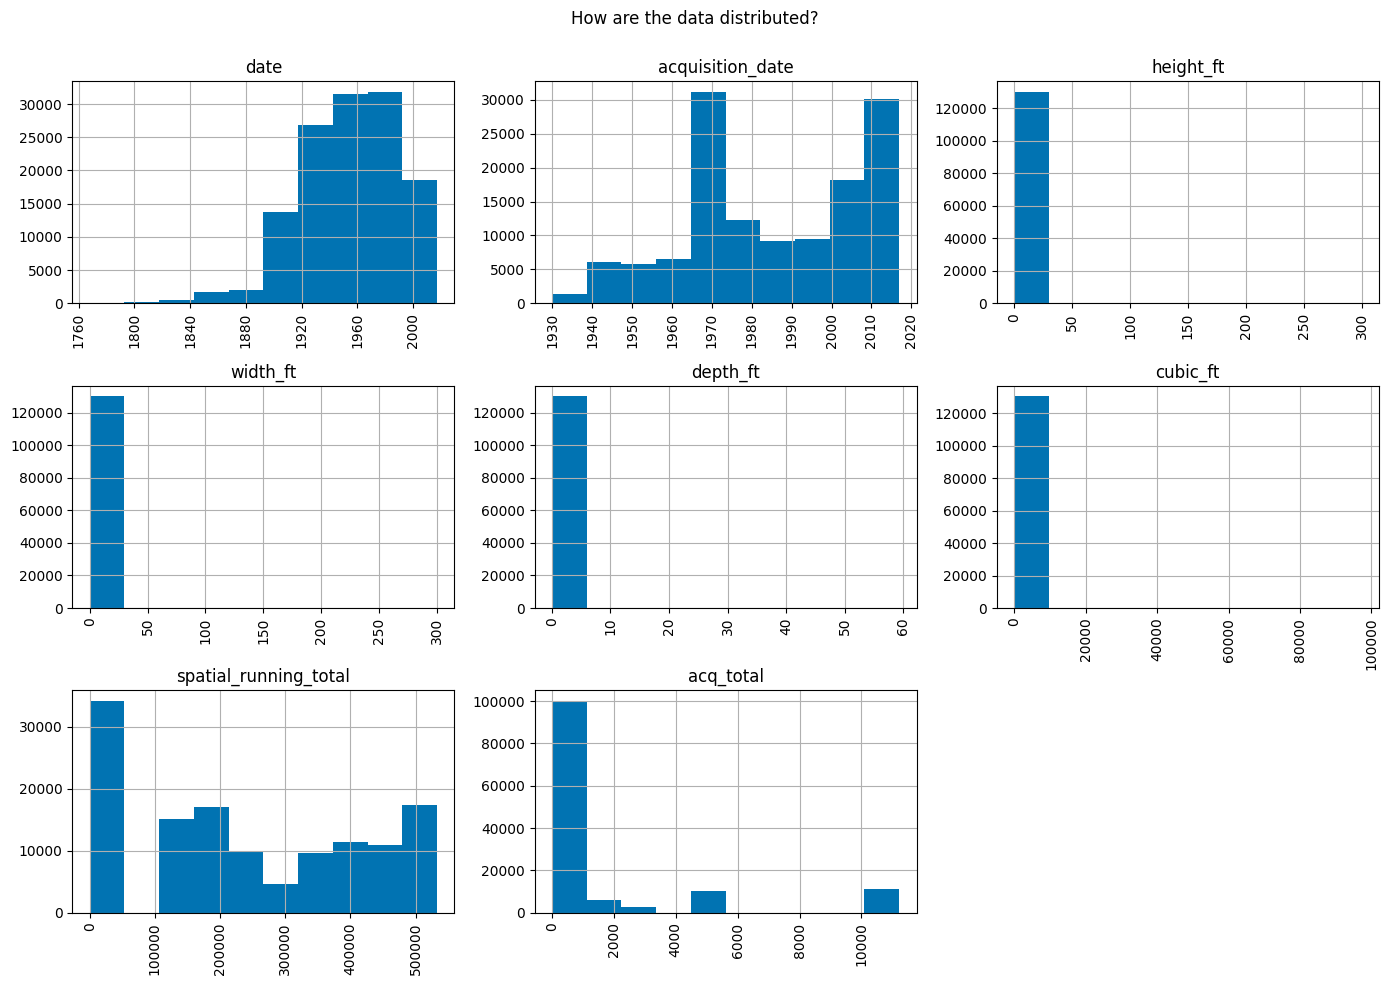

In [16]:
datasets["artworks_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

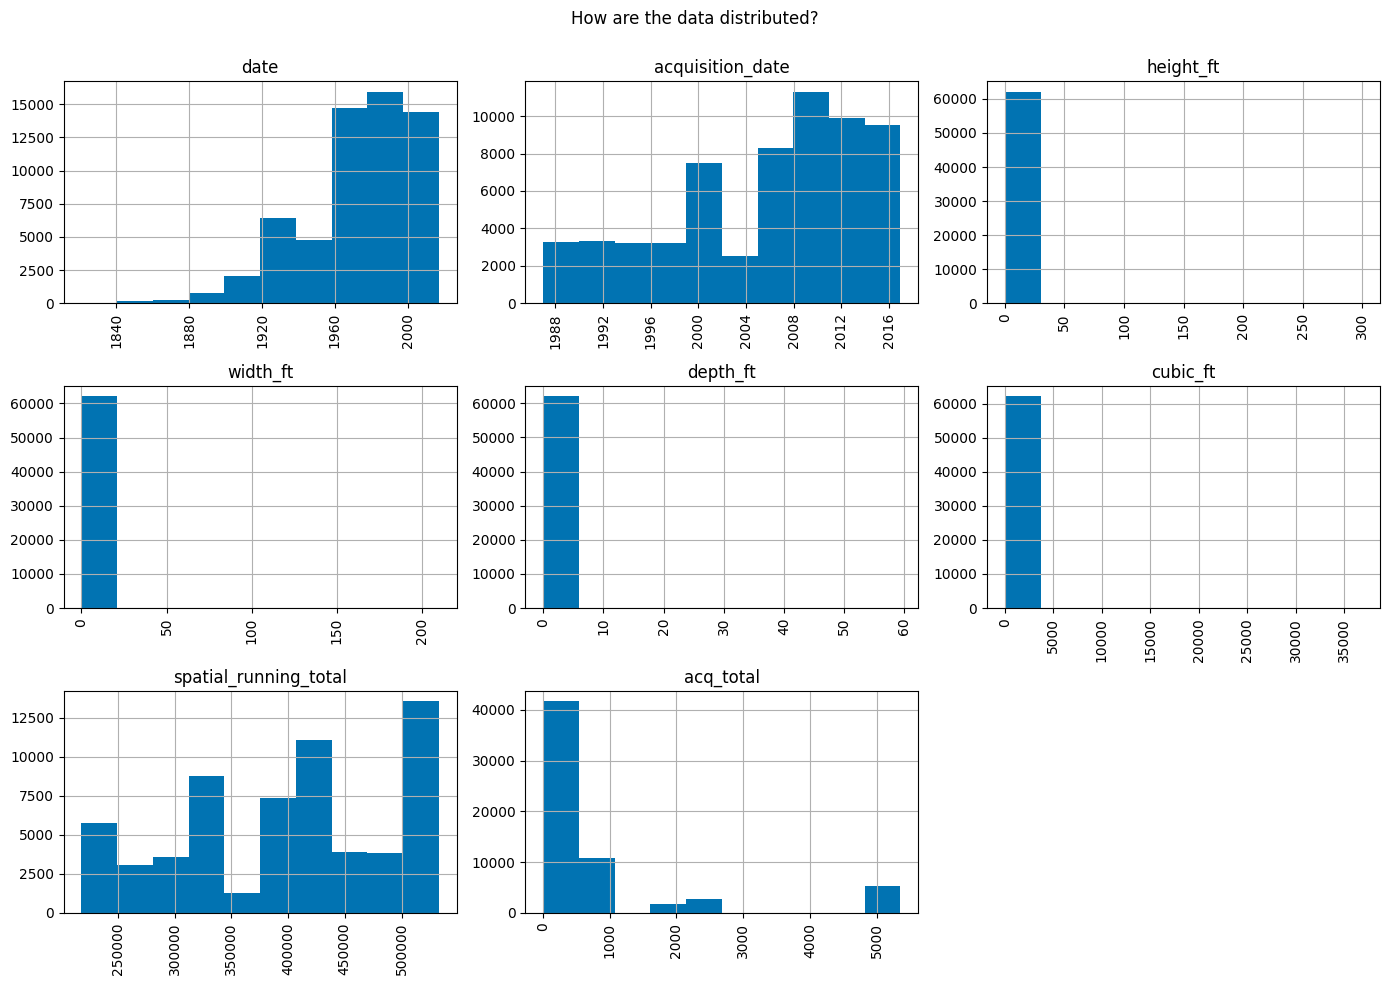

In [17]:
datasets["recent_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

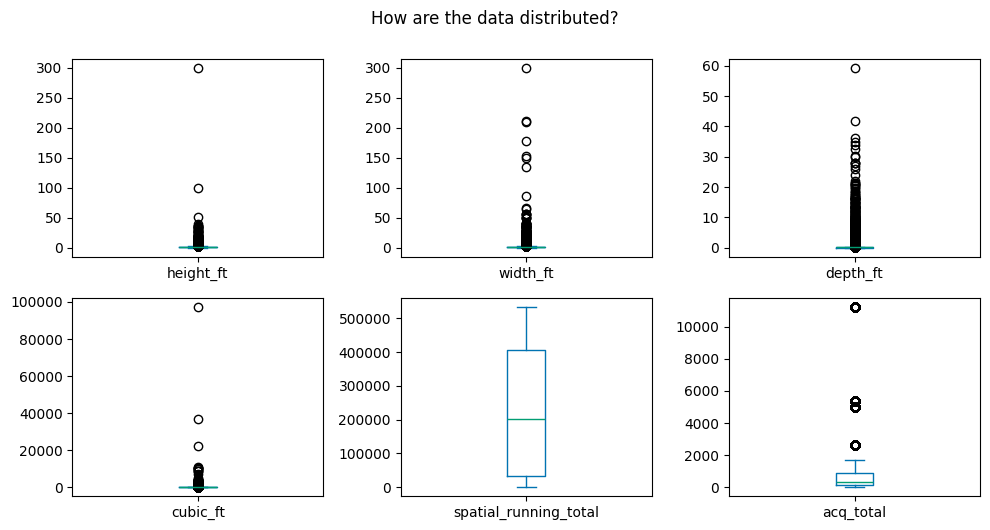

In [18]:
datasets["artworks_data"].plot(
    figsize=(10, 10), 
    kind="box", 
    subplots=True, 
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

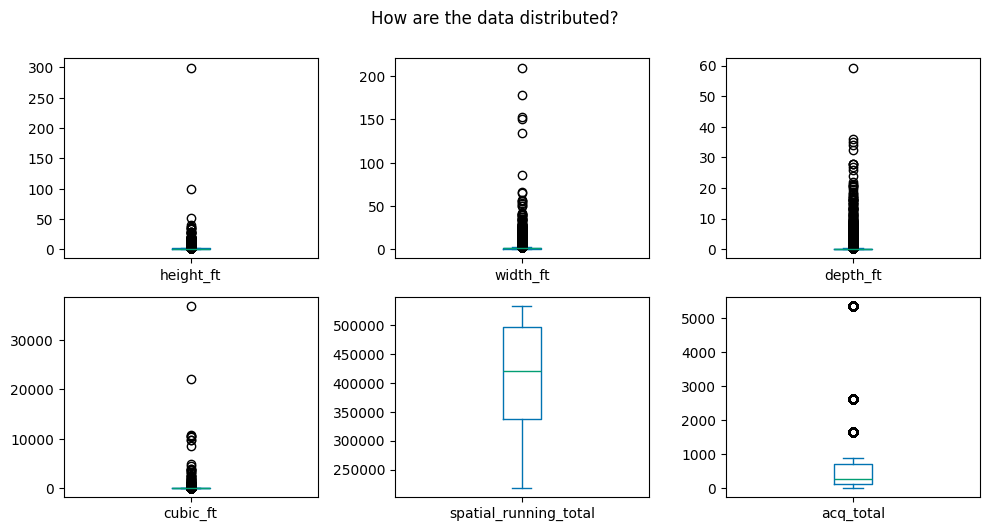

In [19]:
datasets["recent_data"].plot(
    figsize=(10, 10),
    kind="box",
    subplots=True,
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

In [20]:
# TODO: Display which Object Numbers are connected to spatial outliers
outliers = detect_IQR_outliers(datasets["artworks_data"].select_dtypes("number"))

Columns which contain outliers outside of the 25th and 75th percentiles:
height_ft                 True
width_ft                  True
depth_ft                  True
cubic_ft                  True
spatial_running_total    False
acq_total                 True
dtype: bool


In [21]:
# Preparing analysis datasets for later time series forecasting
ts_columns = pd.Index(["day_of_month", "day_of_year", "week_of_month", "week", "month", "year"])

datasets["artworks_data"].loc[:, numerical_columns] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))
datasets["artworks_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))

datasets["recent_data"].loc[:, numerical_columns] = remove_outliers(datasets["recent_data"].select_dtypes("number"))
datasets["recent_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["recent_data"].select_dtypes("number"))

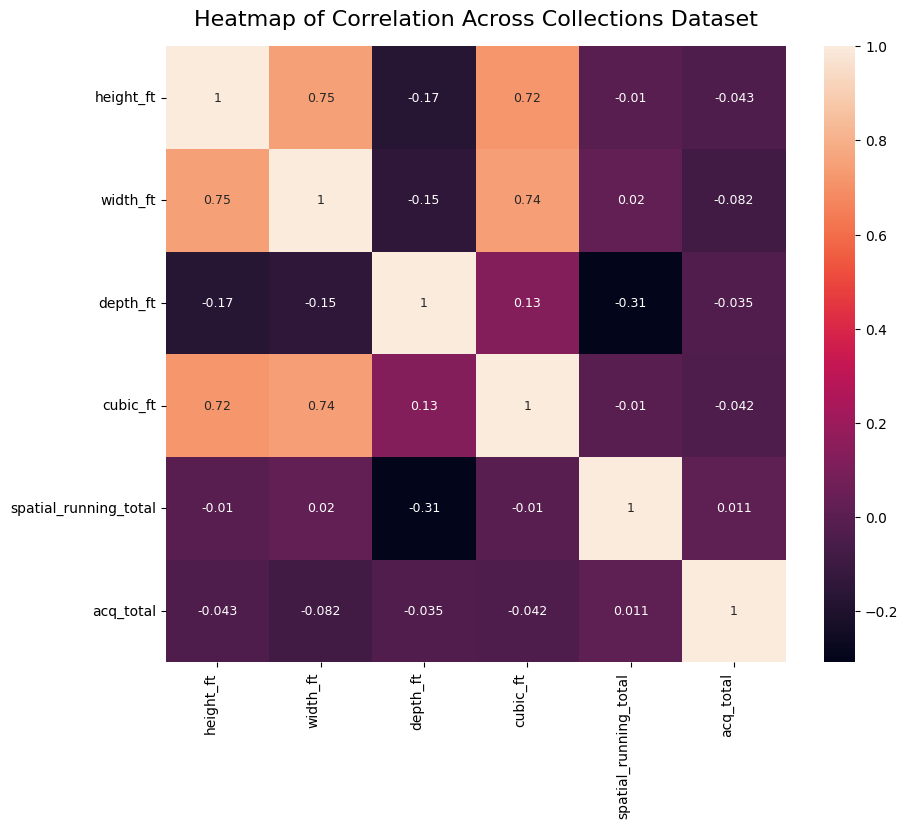

In [22]:
corr_matrix = datasets["artworks_data"].drop(columns=["acq_gaps"]).corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

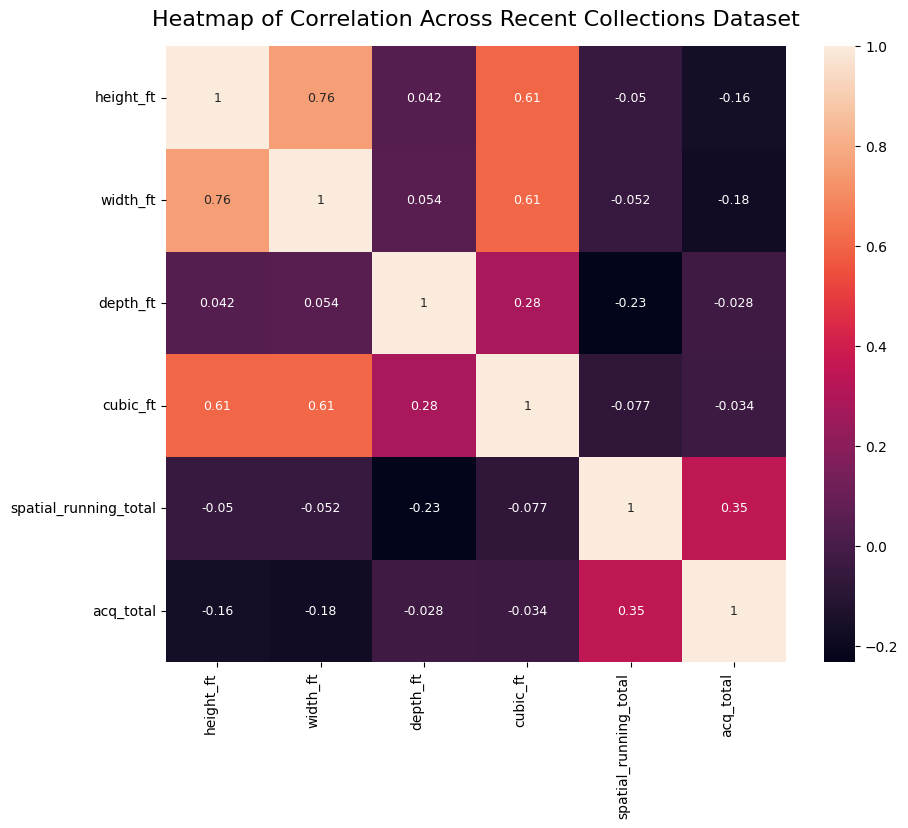

In [23]:
corr_matrix = datasets["recent_data"].drop(columns = ["acq_gaps"]).corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Recent Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

<section id="ts-analysis">
    <h2>Collections Time Series Analysis</h2>
</section>

Explain here why I use the overall dataset and a subset of the overall dataset. Motivated by having the high-level perspective of overall data integrity, and a more nuanced view for interpreting more recent data for estimation purposes.
<br>

<section id="acc-analysis">
    <h3>Accessions Analysis & Decomposition</h3>
</section>

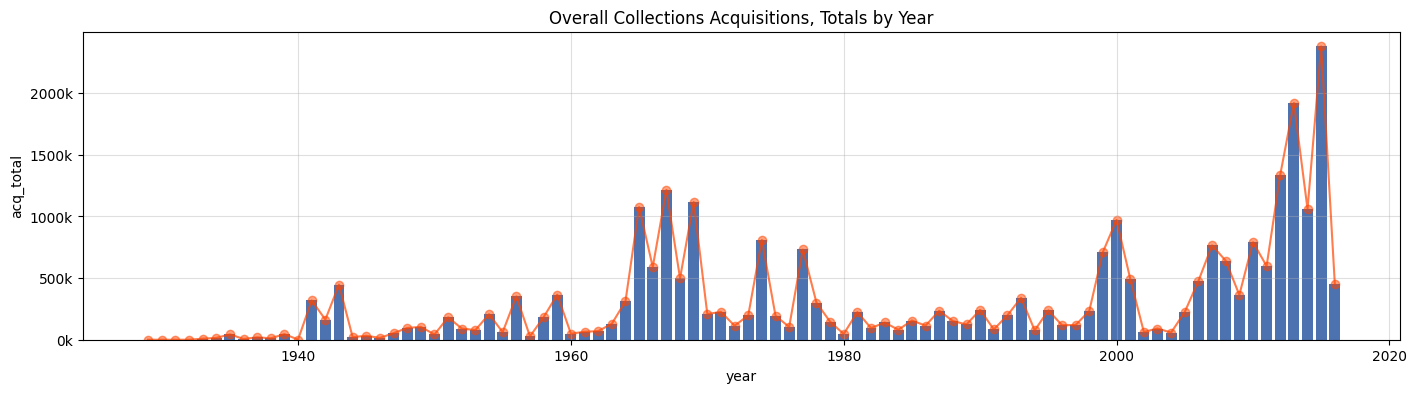

In [24]:
# Accession counts over all-time
yearly_means = datasets["artworks_tsdata"].groupby("year").sum(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.bar(x = "year", height = "acq_total", color = sns.color_palette("deep")[0], data = yearly_means)
sns.lineplot(yearly_means, x = "year", y = "acq_total", color = "orangered", alpha = 0.7)
plt.scatter(x = "year", y = "acq_total", color = "orangered", marker = "o", data = yearly_means, alpha = 0.5)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))
plt.grid(True, alpha = 0.4)
plt.title("Overall Collections Acquisitions, Totals by Year");
plt.show()
plt.close()

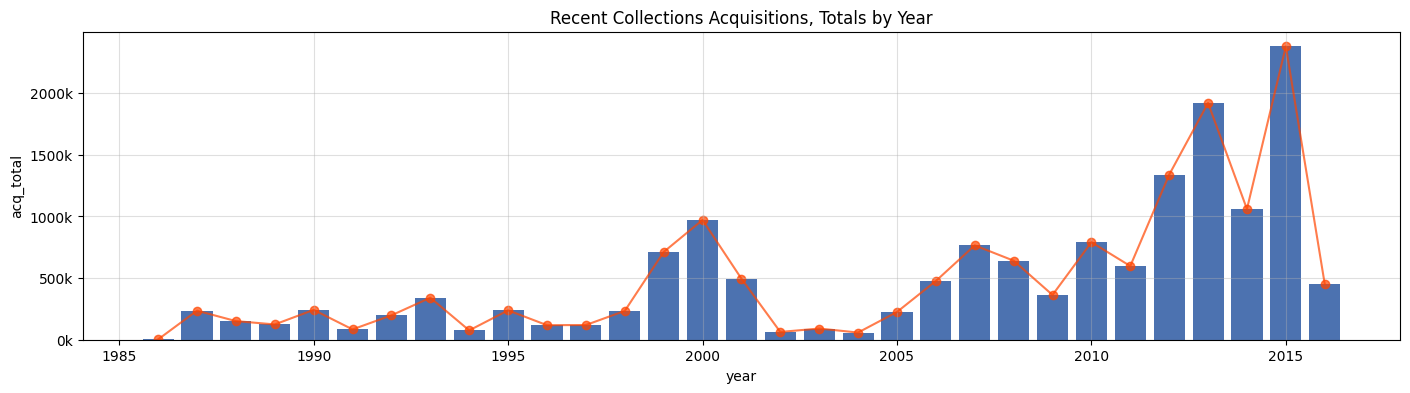

In [25]:
yearly_means = datasets["recent_tsdata"].groupby("year").sum(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.bar(x = "year", height = "acq_total", color = sns.color_palette("deep")[0], data = yearly_means)
sns.lineplot(yearly_means, x = "year", y = "acq_total", color = "orangered", alpha = 0.7)
plt.scatter(x = "year", y = "acq_total", color = "orangered", marker = "o", data = yearly_means, alpha = 0.7)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))
plt.grid(True, alpha = 0.4)
plt.title("Recent Collections Acquisitions, Totals by Year");
plt.show()
plt.close()

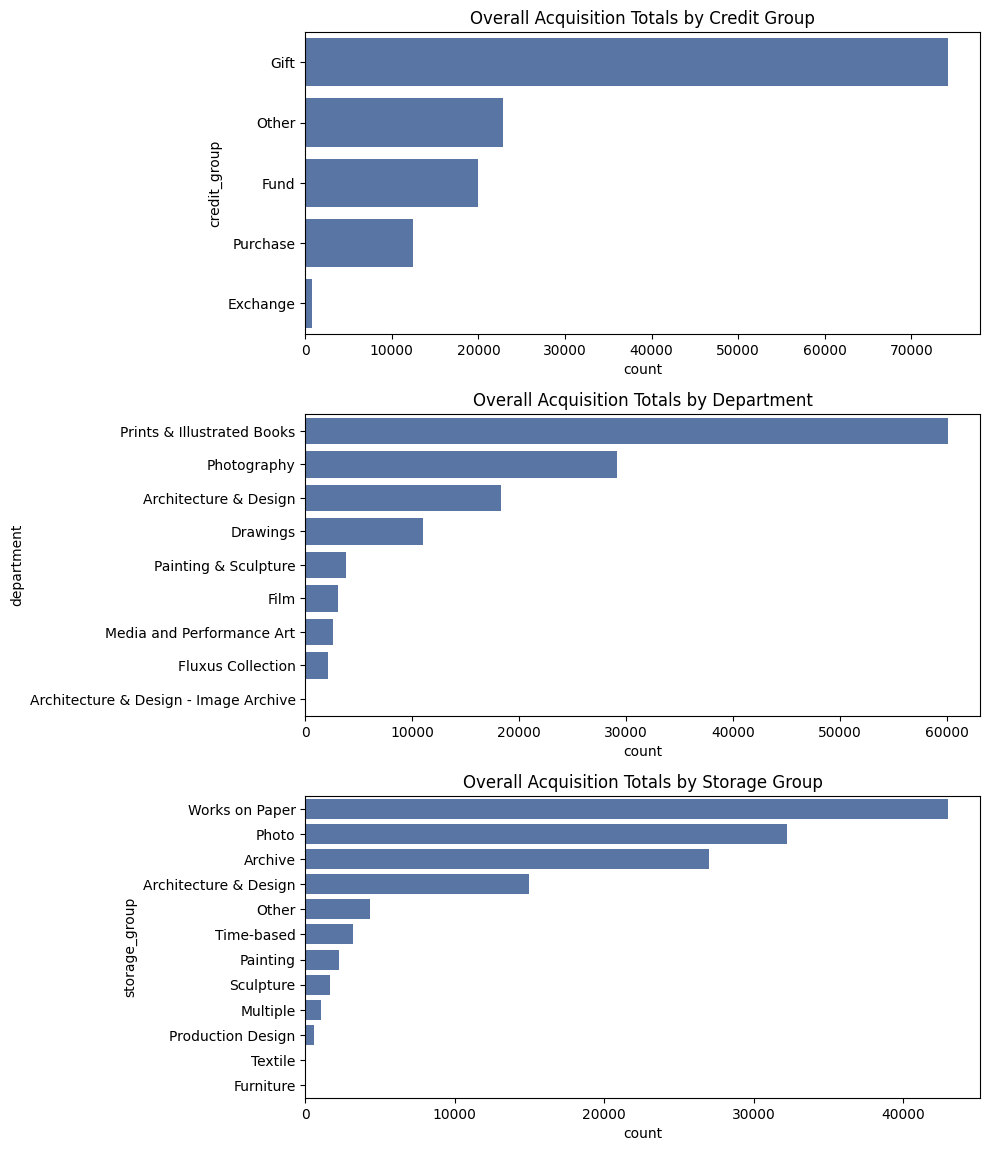

In [26]:
# Overall accession counts by credit, department, and storage group
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["artworks_tsdata"],
        # sorts plots by descending order for visual clarity
        order = datasets["artworks_tsdata"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Overall Acquisition Totals by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

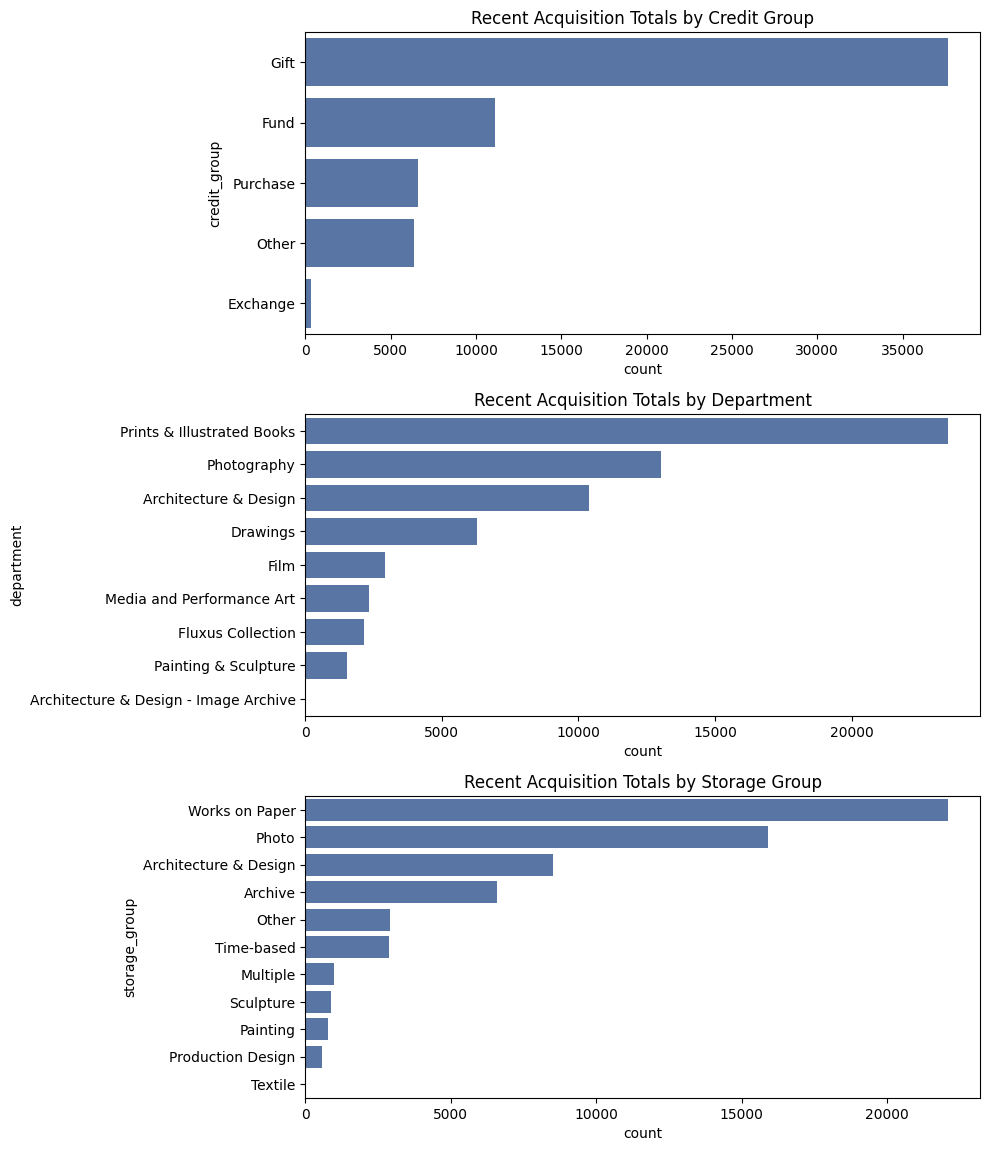

In [27]:
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["recent_tsdata"],
        # sorts plots by descending order for visual clarity
        order = datasets["recent_tsdata"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Recent Acquisition Totals by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

<section id="gap-analysis">
    <h2>Time Series Analysis of Acquisition Counts</h2>
</section>

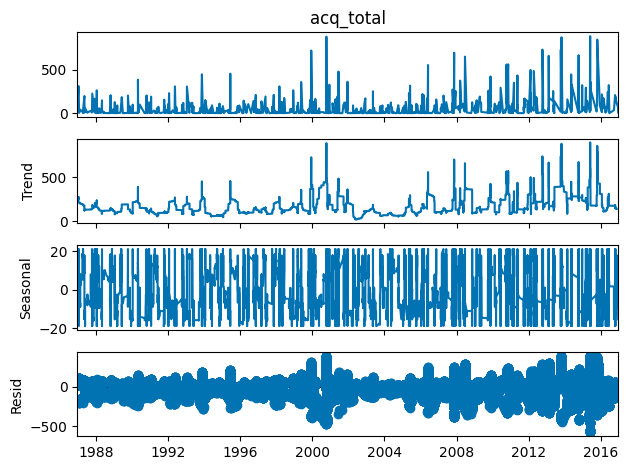

In [28]:
ts_data = (datasets["recent_tsdata"]
           .set_index("acquisition_date")
           .sort_index()
           ["acq_total"]
           .dropna())
decomposition = sm.tsa.seasonal_decompose(ts_data, model="additive", period = 365)
decomposition.plot();

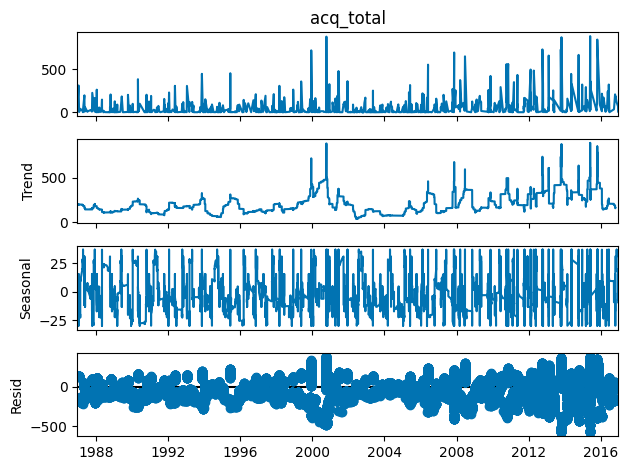

In [29]:
decomposition = sm.tsa.seasonal_decompose(ts_data, model="additive", period = (365 * 2))
decomposition.plot();

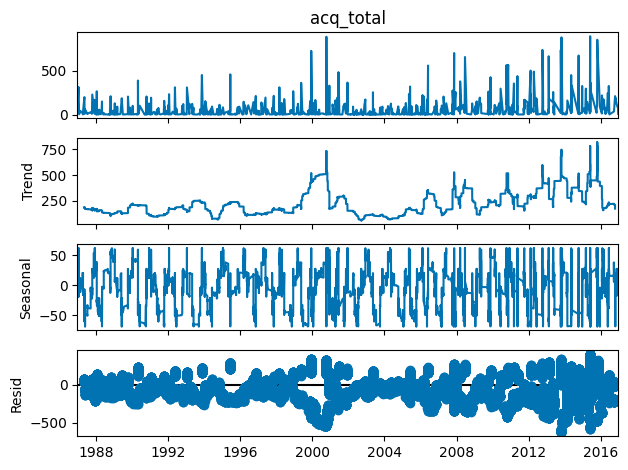

In [30]:
decomposition = sm.tsa.seasonal_decompose(ts_data, model="additive", period = (365 * 3))
decomposition.plot();

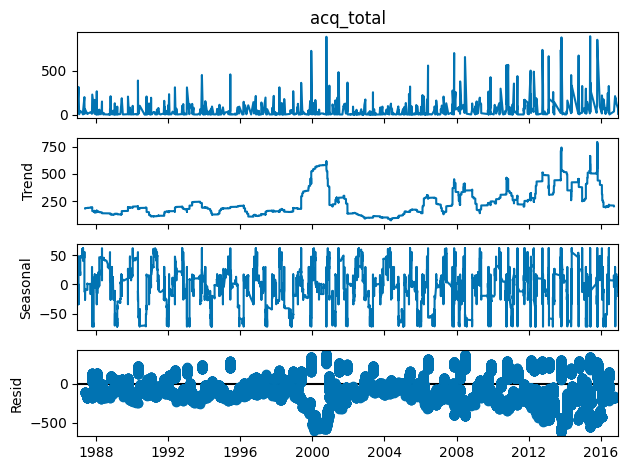

In [31]:
decomposition = sm.tsa.seasonal_decompose(ts_data, model="additive", period = (365 * 4))
decomposition.plot();

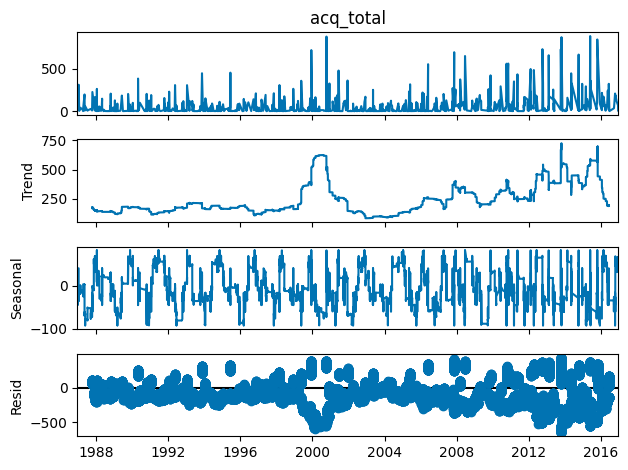

In [32]:
decomposition = sm.tsa.seasonal_decompose(ts_data, model="additive", period = (365 * 5))
decomposition.plot();

In [33]:
n = 25
print("Overall Durations of Gaps in between Acquisitions")
print(f"\nTop {n} Most Common gap durations:\n", datasets["artworks_tsdata"]["acq_gaps"].value_counts().head(n))

Overall Durations of Gaps in between Acquisitions

Top 25 Most Common gap durations:
 acq_gaps
0 days     128389
1 days        317
2 days        137
3 days        112
5 days         88
4 days         84
6 days         79
7 days         78
8 days         61
9 days         54
10 days        42
28 days        40
11 days        40
21 days        39
13 days        39
15 days        38
12 days        37
14 days        36
18 days        33
19 days        33
20 days        32
22 days        29
16 days        25
26 days        24
17 days        23
Name: count, dtype: int64


In [34]:
print(f"Recent Durations of Gaps in between Acquisitions")
print("Shortest gap:", datasets["recent_tsdata"]["acq_gaps"].min())
print("Longest gap:", datasets["recent_tsdata"]["acq_gaps"].max())
print(f"\nTop {n} Most Common gap durations:\n", datasets["recent_tsdata"]["acq_gaps"].value_counts().head(n))

Recent Durations of Gaps in between Acquisitions
Shortest gap: 0 days
Longest gap: 97 days

Top 25 Most Common gap durations:
 acq_gaps
0 days     61146
1 days       224
2 days        84
3 days        70
5 days        51
4 days        46
6 days        45
7 days        43
8 days        29
9 days        28
11 days       24
10 days       23
15 days       22
12 days       22
18 days       21
13 days       21
20 days       20
19 days       16
21 days       14
14 days       14
16 days       12
27 days       12
22 days       10
26 days        9
23 days        9
Name: count, dtype: int64


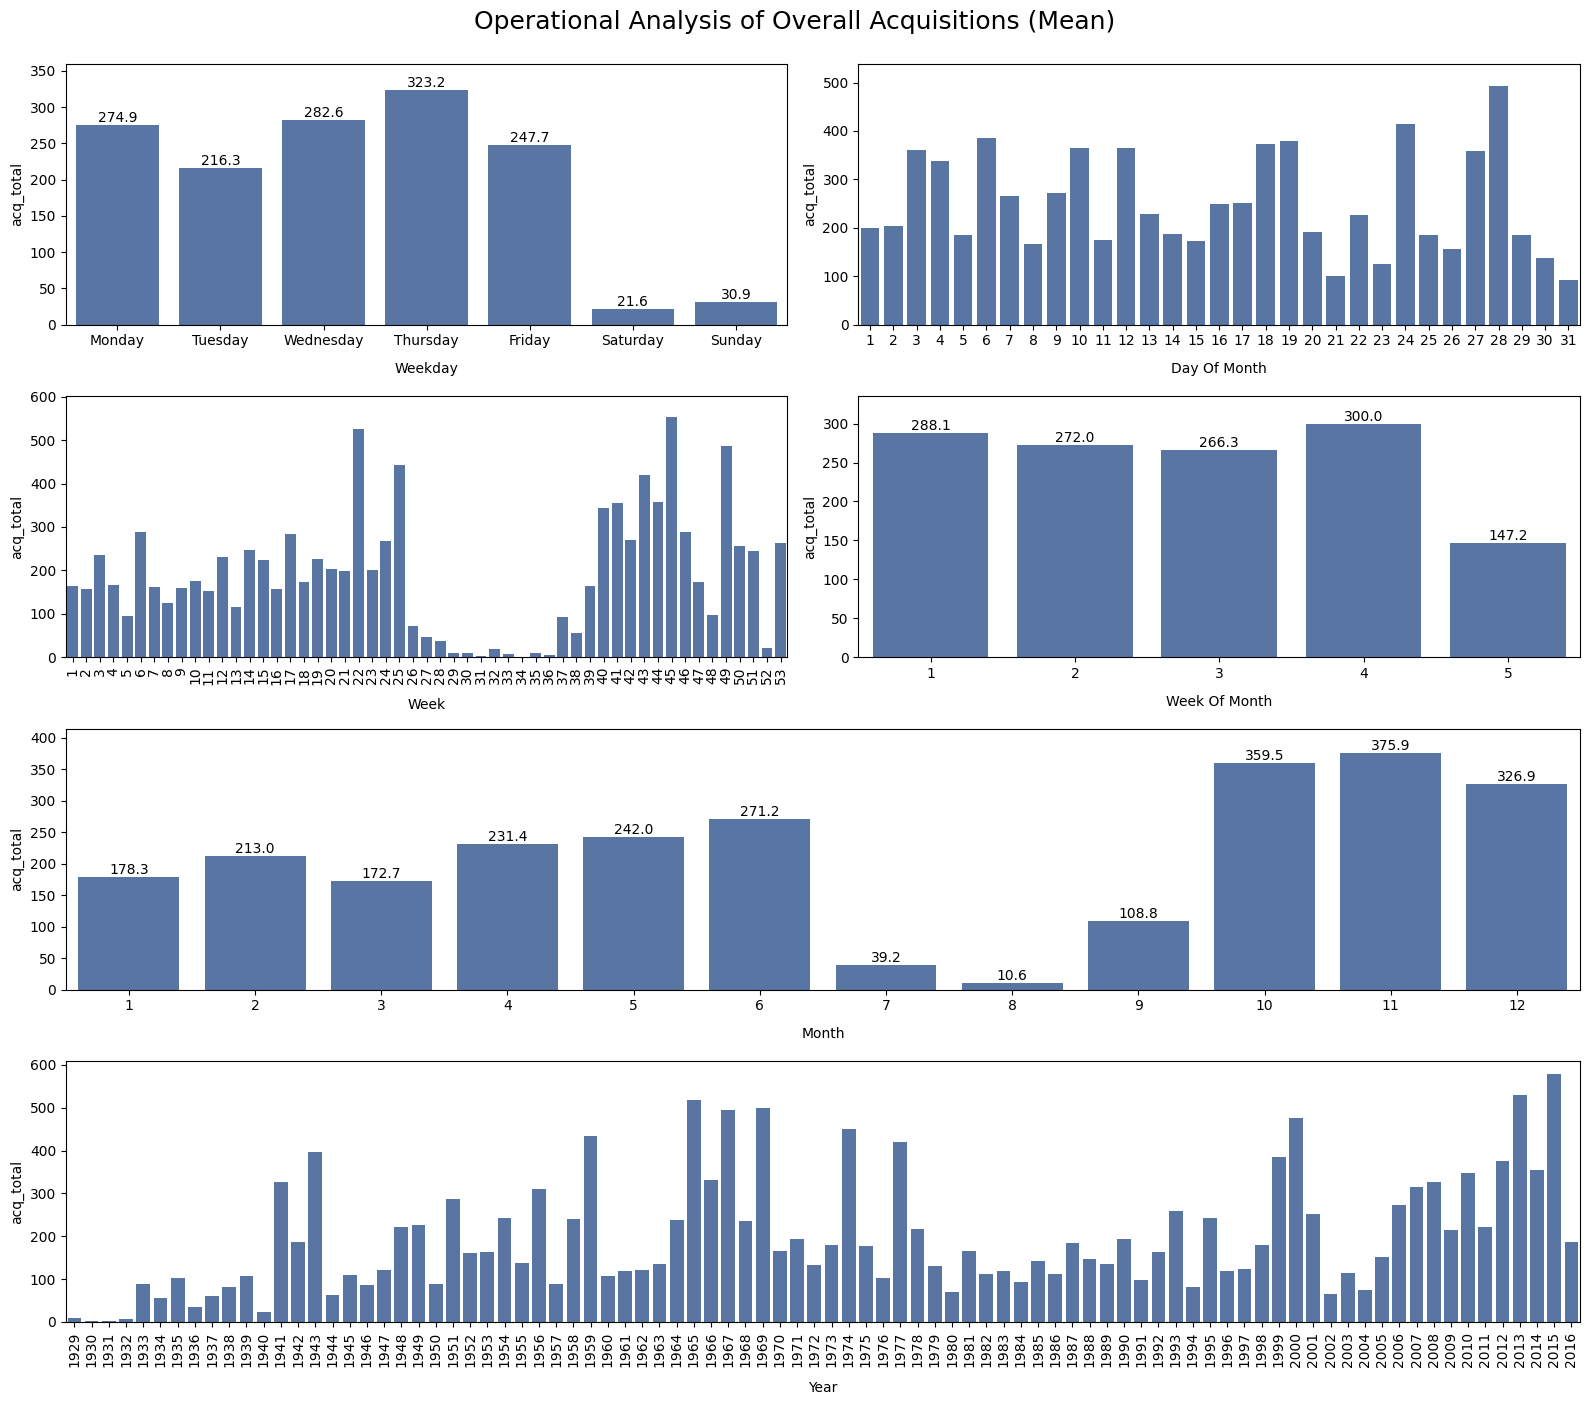

In [35]:
stat = "mean"
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Operational Analysis of Overall Acquisitions ({stat.title()})", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["artworks_tsdata"], x = column, y = "acq_total", 
                ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False),
                estimator = stat)
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    # Increase the ymax by 10
    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin, ymax + 20])
    if len(datasets["artworks_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "month", y = "acq_total", 
            ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False),
            estimator = stat)
combined_ax.set_xlabel("month".title(), labelpad = 10)
# Increase the ymax by 10
ymin, ymax = combined_ax.get_ylim()
combined_ax.set_ylim([ymin, ymax + 20])
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.1f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "year", y = "acq_total",
            ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False),
            estimator = stat)
combined_ax2.set_xlabel("year".title(), labelpad = 10)

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

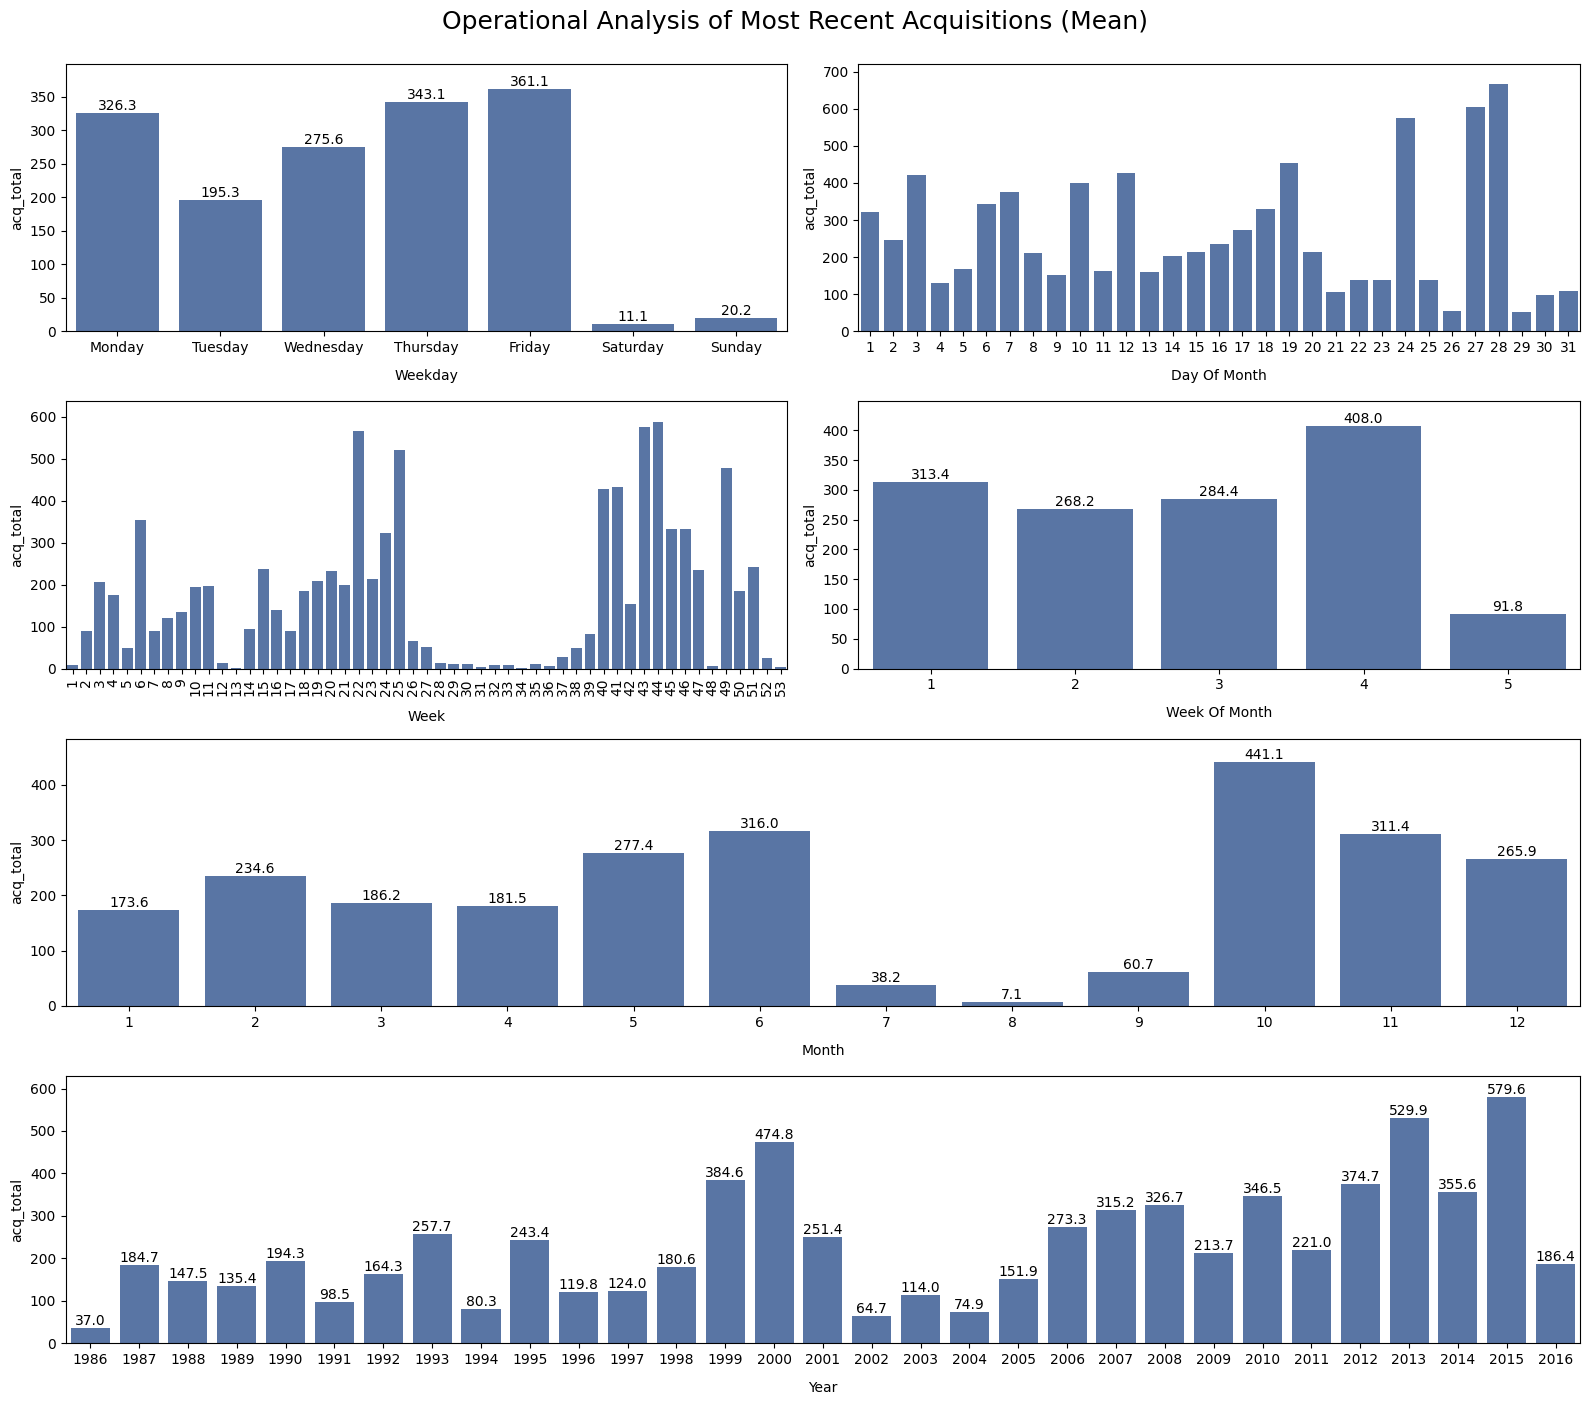

In [36]:
# stat = "mean"
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Operational Analysis of Most Recent Acquisitions ({stat.title()})", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["recent_tsdata"], x = column, y = "acq_total",
                ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False),
                estimator = stat)
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    # Increase the ymax by 10
    ymin, ymax = ax.get_ylim()
    ax.set_ylim([ymin, ymax + 20])
    if len(datasets["recent_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "month", y = "acq_total",
            ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False),
            estimator = stat)
combined_ax.set_xlabel("month".title(), labelpad = 10)
# Increase the ymax by 10
ymin, ymax = combined_ax.get_ylim()
combined_ax.set_ylim([ymin, ymax + 20])
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "year", y = "acq_total",
            ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False),
            estimator = stat)
combined_ax2.set_xlabel("year".title(), labelpad = 10)
# Increase the ymax by 10
ymin, ymax = combined_ax2.get_ylim()
combined_ax2.set_ylim([ymin, ymax + 20])
for p in combined_ax2.patches:
    combined_ax2.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
# combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

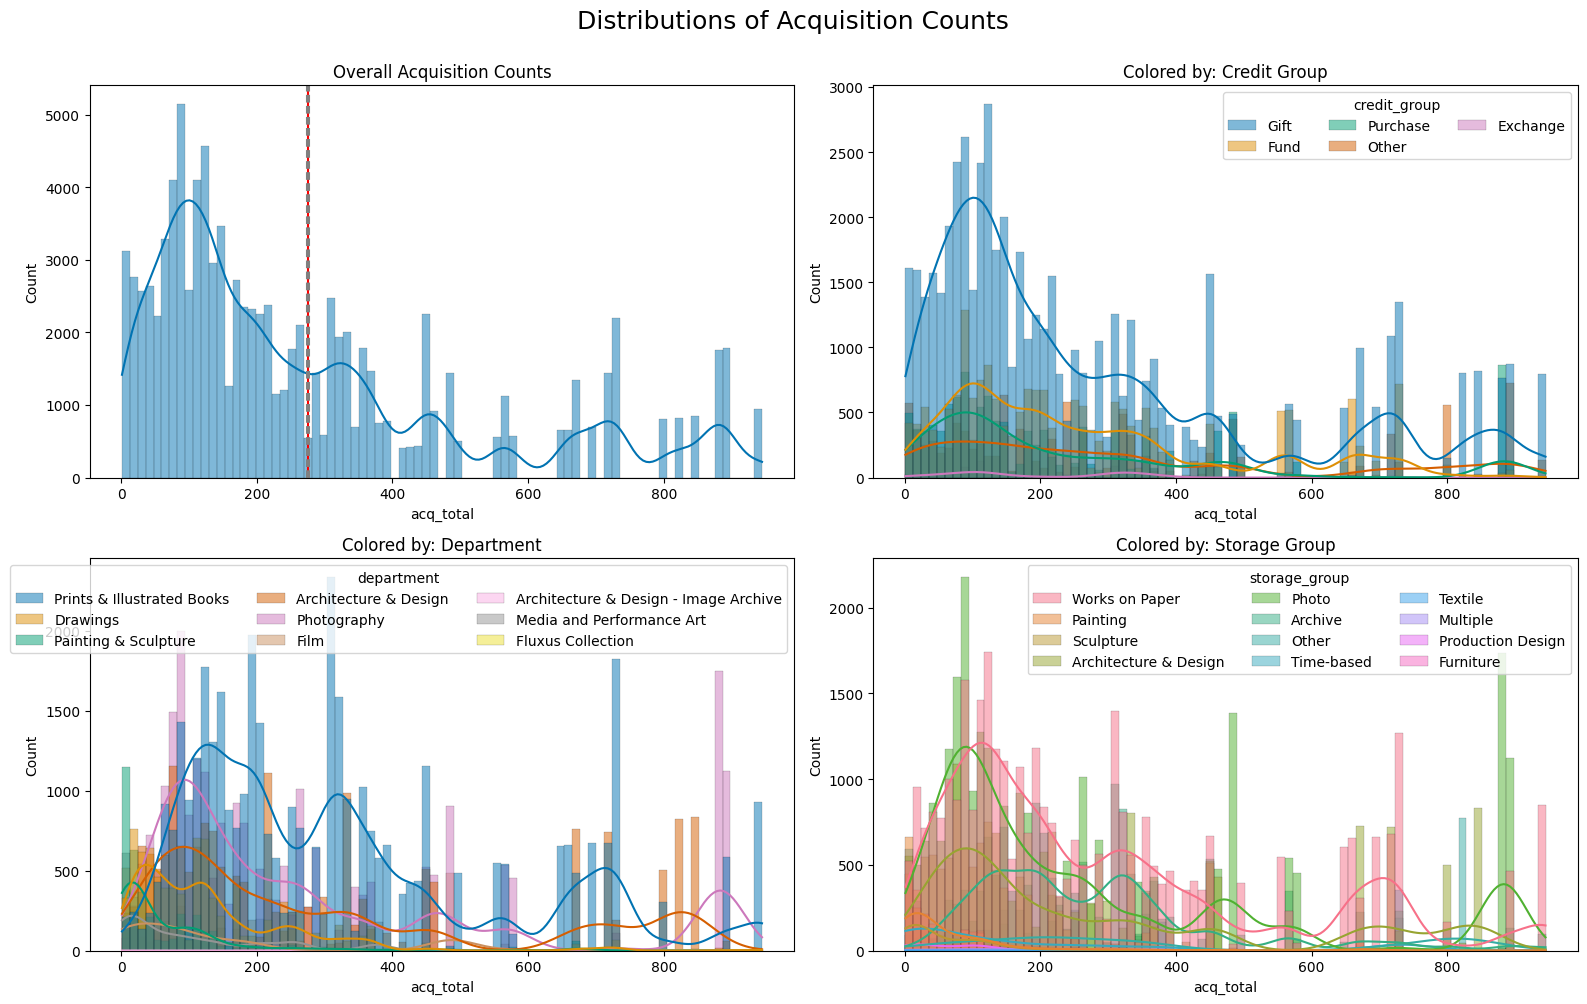

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Acquisition Counts", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["artworks_tsdata"], "acq_total")
sns.histplot(data=datasets["artworks_tsdata"], x = "acq_total", kde = True, ax = axs[0, 0],  linewidth = 0.1)
axs[0, 0].axvline(np.mean(datasets["artworks_tsdata"]["acq_total"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Counts")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["artworks_tsdata"], x = "acq_total", hue = column, kde = True, ax = ax,  linewidth = 0.1)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

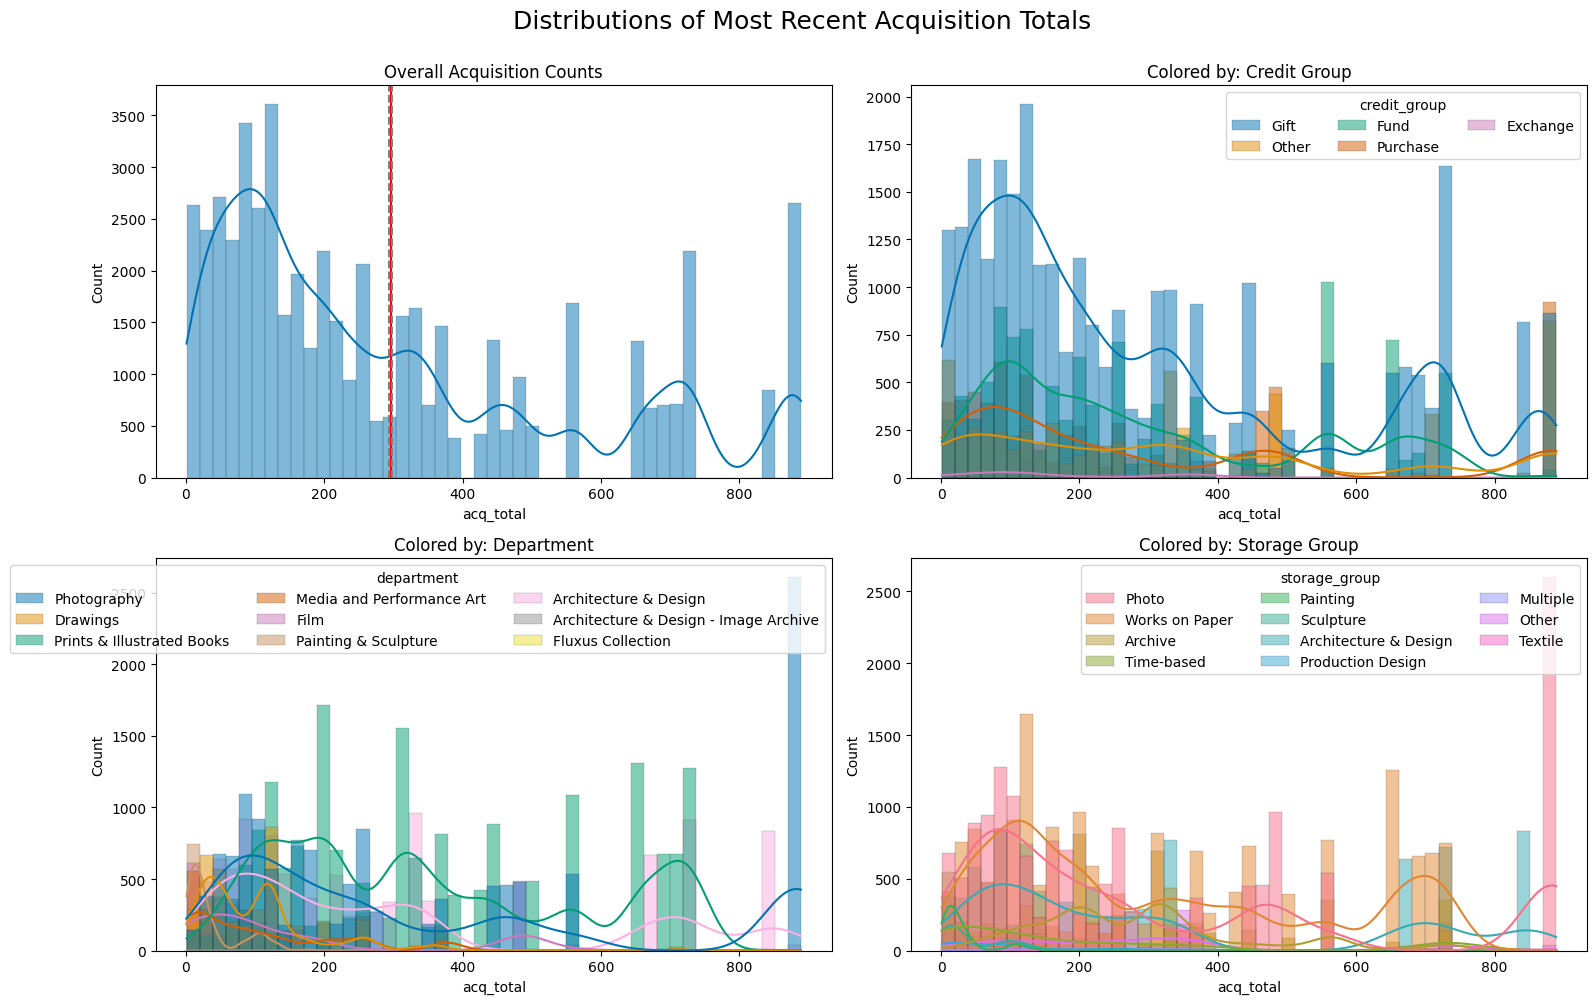

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Most Recent Acquisition Totals", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["recent_tsdata"], "acq_total")
sns.histplot(data=datasets["recent_tsdata"], x = "acq_total", kde = True, ax = axs[0, 0], linewidth = 0.1)
axs[0, 0].axvline(np.mean(datasets["recent_tsdata"]["acq_total"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Counts")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["recent_tsdata"], x = "acq_total", hue = column, kde = True, ax = ax, linewidth = 0.1)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

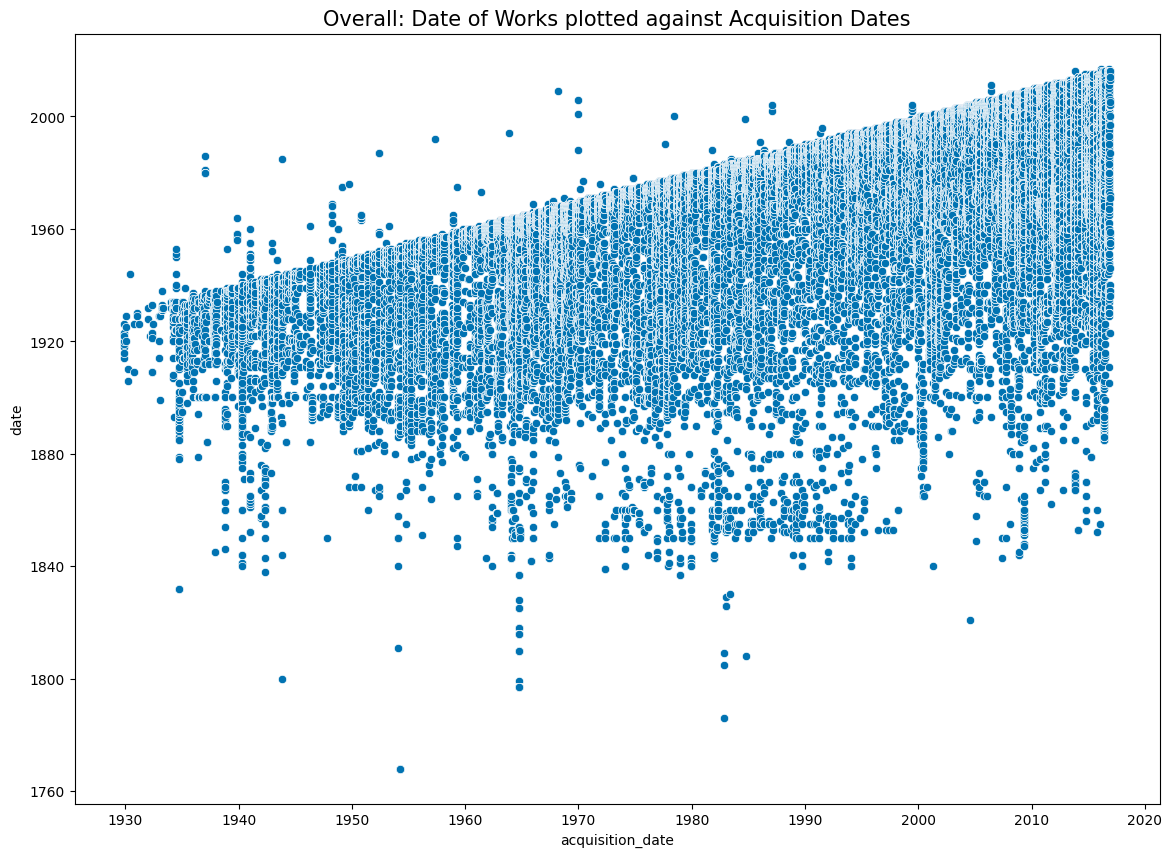

In [39]:
# Table: How contemporary are the intake practices of the NYC MoMA?
plt.figure(figsize = (14, 10))
sns.scatterplot(datasets["artworks_tsdata"], x = "acquisition_date", y = "date")
plt.title("Overall: Date of Works plotted against Acquisition Dates", fontsize = 15, y = 1.0);

<section id="spatial-stats">
    <h2>Spatial Descriptive Statistics - Histograms, Boxplots, and Totals by [Overall, Credit, Dept, Storage_Group]</h2>
</section>

In [40]:
datasets["artworks_tsdata"].groupby("department").sum(numeric_only = True).sort_values(by = "acq_total", ascending = False)

height_ft  width_ft  depth_ft  \
department                                                             
Prints & Illustrated Books             52984.123 49841.257  6630.513   
Photography                            24695.562 26385.308  4007.433   
Architecture & Design                  15625.221 18296.495   357.364   
Drawings                               10947.603 10337.064   817.410   
Film                                    2664.610  2966.237   353.395   
Painting & Sculpture                    1823.896  1992.251    28.069   
Media and Performance Art               1482.965  1427.010    93.822   
Architecture & Design - Image Archive     13.339    16.376     1.386   
Fluxus Collection                        629.297   687.444    65.302   

                                       cubic_ft  spatial_running_total  \
department                                                               
Prints & Illustrated Books             4617.779        11926702320.282   
Photography                            2830.090         7088113511.535   
Architecture & Design                   592.497         5191636391.845   
Drawings                                828.815         2860782179.706   
Film                                    328.508         1344158812.955   
Painting & Sculpture                     34.294          759438105.709   
Media and Performance Art                39.222         1022944867.758   
Architecture & Design - Image Archive     0.664            9546422.872   
Fluxus Collection                        48.505          911697731.875   

                                         acq_total  day_of_month  day_of_year  \
department                                                                      
Prints & Illustrated Books            13091888.000        704021     12126155   
Photography                            6793183.000        356971      4816545   
Architecture & Design                  5552043.000        236592      3723440   
Drawings                               1105564.000        134261      1866956   
Film                                    455538.000         32852       529240   
Painting & Sculpture                    284567.000         46228       768488   
Media and Performance Art               266173.000         33951       452004   
Architecture & Design - Image Archive     6756.000           238         4946   
Fluxus Collection                            0.000         17080       602070   

                                       week_of_month     week   month  \
department                                                              
Prints & Illustrated Books                    125778  1770788  436339   
Photography                                    61852   703797  176436   
Architecture & Design                          42074   546440  133219   
Drawings                                       24178   273468   68265   
Film                                            6197    80607   19463   
Painting & Sculpture                            8335   111977   27622   
Media and Performance Art                       6268    67896   16434   
Architecture & Design - Image Archive             42      722     176   
Fluxus Collection                               4270    87535   21350   

                                            year  
department                                        
Prints & Illustrated Books             119047929  
Photography                             57858006  
Architecture & Design                   36319707  
Drawings                                21903832  
Film                                     6197182  
Painting & Sculpture                     7530060  
Media and Performance Art                5263652  
Architecture & Design - Image Archive      42187  
Fluxus Collection                        4287080

In [41]:
datasets["recent_tsdata"].groupby("department").sum(numeric_only = True).sort_values(by = "acq_total", ascending = False)

height_ft  width_ft  depth_ft  \
department                                                             
Prints & Illustrated Books             20570.535 19628.268  2215.535   
Photography                            11180.837 12160.966  1705.342   
Architecture & Design                   8874.912  9530.997   193.363   
Film                                    2507.325  2805.716   330.117   
Drawings                                5997.457  5726.717   451.241   
Media and Performance Art               1327.163  1275.081    84.882   
Painting & Sculpture                     582.012   660.223    16.321   
Architecture & Design - Image Archive     12.547    15.251     1.386   
Fluxus Collection                        629.297   687.444    65.302   

                                       cubic_ft  spatial_running_total  \
department                                                               
Prints & Illustrated Books             1708.792         9085432930.351   
Photography                            1122.929         5086258759.986   
Architecture & Design                   404.733         4457542710.515   
Film                                    307.408         1329310705.050   
Drawings                                440.445         2419642599.588   
Media and Performance Art                37.234          967412493.279   
Painting & Sculpture                     17.123          573011667.195   
Architecture & Design - Image Archive     0.664            9531927.126   
Fluxus Collection                        50.665          911697731.875   

                                        acq_total  day_of_month  day_of_year  \
department                                                                     
Prints & Illustrated Books            6685418.000        307313      4331459   
Photography                           4529603.000        180176      2600919   
Architecture & Design                 3191343.000        136305      2112480   
Film                                   451551.000         32404       515895   
Drawings                               376587.000         70508      1013485   
Media and Performance Art              262278.000         30951       404625   
Painting & Sculpture                    58270.000         14903       315192   
Architecture & Design - Image Archive    6748.000           237         4945   
Fluxus Collection                           0.000         17080       602070   

                                       week_of_month    week   month      year  
department                                                                      
Prints & Illustrated Books                     55673  632339  156152  47141319  
Photography                                    30864  377671   92910  26072384  
Architecture & Design                          24259  308531   75538  20837344  
Film                                            5996   75708   18865   5860513  
Drawings                                       12971  148088   37459  12566422  
Media and Performance Art                       5671   60849   14693   4710658  
Painting & Sculpture                            2816   46105   11421   3042909  
Architecture & Design - Image Archive             41     721     175     40234  
Fluxus Collection                               4270   87535   21350   4287080

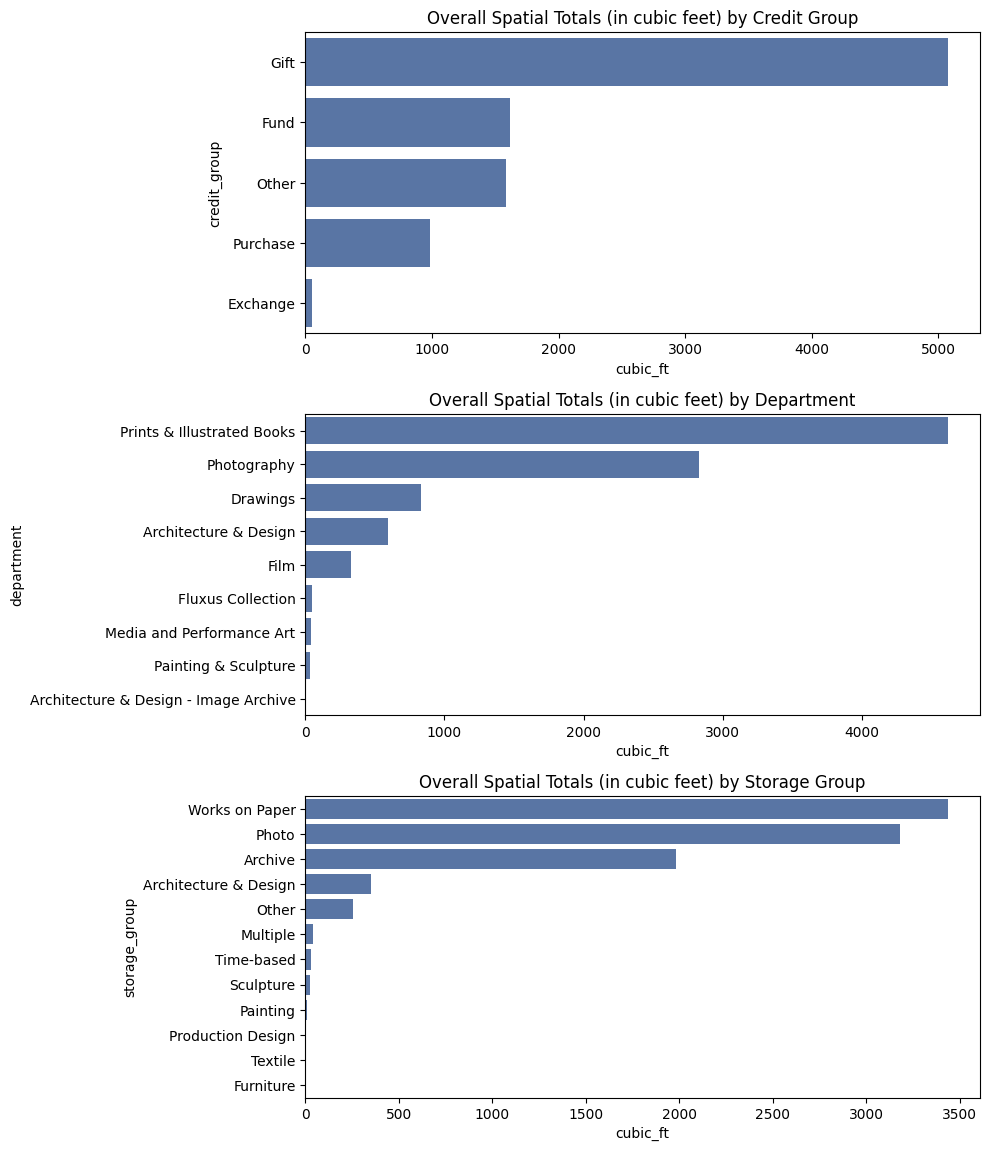

In [42]:
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    data = datasets["artworks_tsdata"].groupby(category).sum("cubic_ft").sort_values(by = "cubic_ft", ascending = False)
    # Spatial Totals (in cubic feet)
    plt.subplot(4, 1, idx)
    sns.barplot(
        y = category,
        x = "cubic_ft",
        data = data,
        # sorts plots by descending order for visual clarity
        order = data.index,
        color = sns.color_palette("deep")[0],
        estimator = sum
    )
    plt.title(f"Overall Spatial Totals (in cubic feet) by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

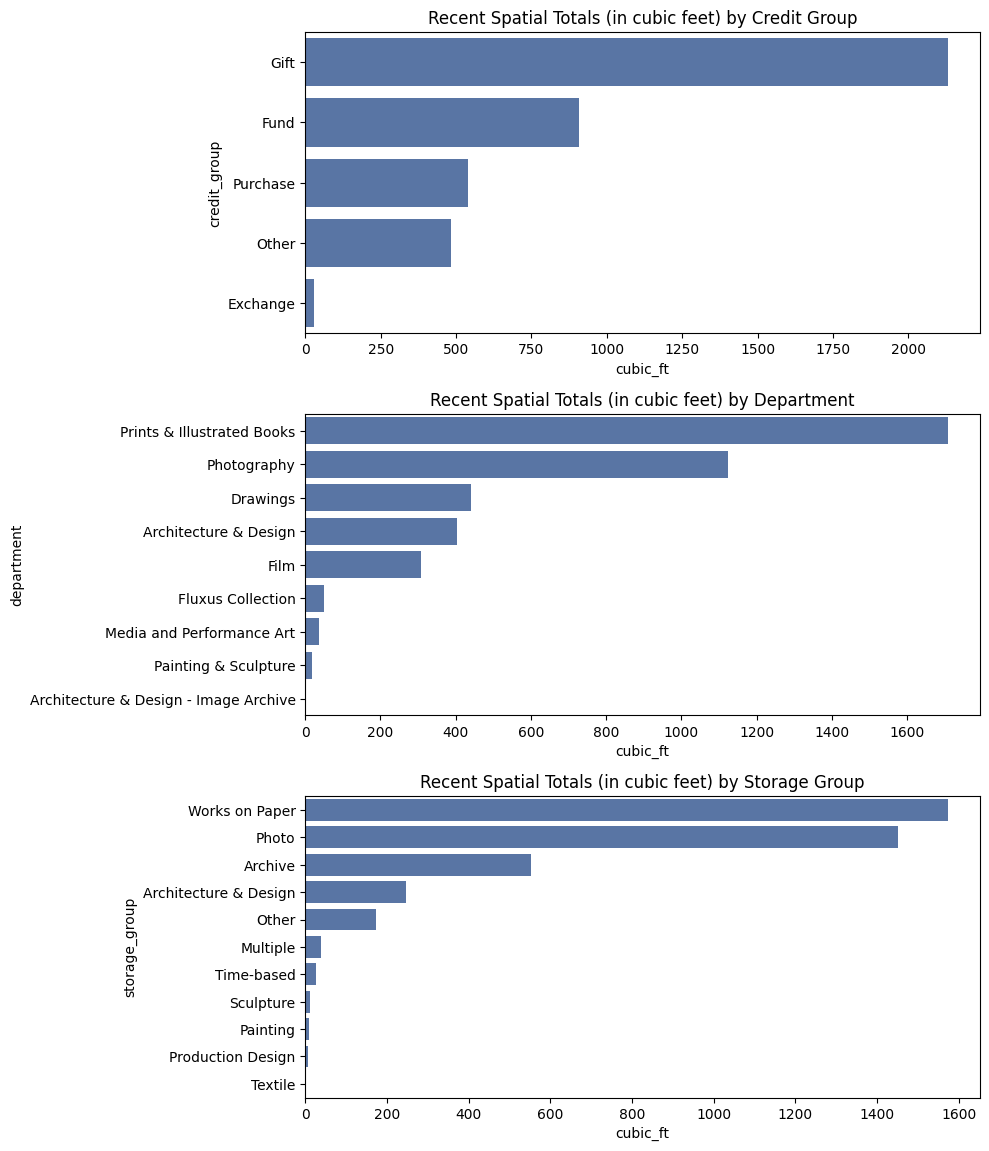

In [43]:
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    data = datasets["recent_tsdata"].groupby(category).sum("cubic_ft").sort_values(by = "cubic_ft", ascending = False)
    # Spatial Totals (in cubic feet)
    plt.subplot(4, 1, idx)
    sns.barplot(
        y = category,
        x = "cubic_ft",
        data = data,
        # sorts plots by descending order for visual clarity
        order = data.index,
        color = sns.color_palette("deep")[0],
        estimator = sum
    )
    plt.title(f"Recent Spatial Totals (in cubic feet) by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

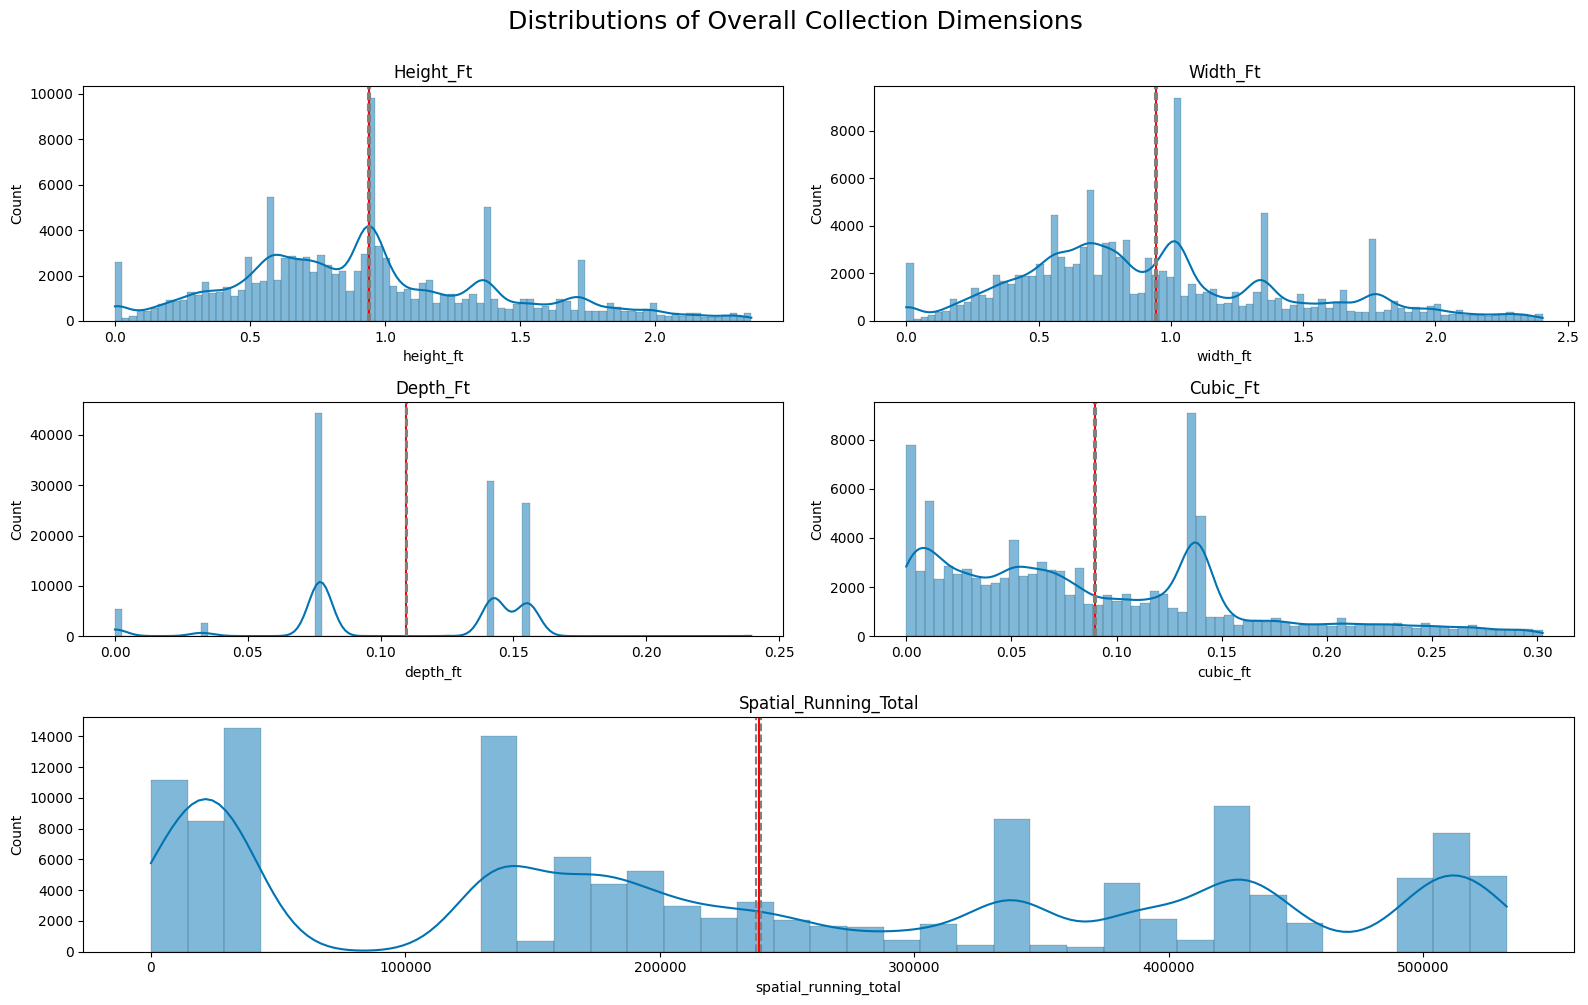

In [44]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))
plt.suptitle(f"Distributions of Overall Collection Dimensions", fontsize = 18, y = 1.0)

for i, column in enumerate(spatial_columns[:-1]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    ci = calculate_confidence_intervals_95(datasets["artworks_tsdata"], column)
    sns.histplot(data=datasets["artworks_tsdata"], x = column, ax = ax, kde = True, linewidth = 0.1)
    ax.axvline(np.mean(datasets["artworks_tsdata"][column]), color = "red")
    ax.axvline(ci[0], color="gray", linestyle = "--")
    ax.axvline(ci[1], color="gray", linestyle = "--")
    ax.set_title(column.title())
axs[2, 1].remove()
axs[2, 0].remove()

combined_ax = fig.add_subplot(3, 1, 3)  # combined plot row
sns.histplot(data = datasets["artworks_tsdata"], x = "spatial_running_total", ax = combined_ax, kde = True, linewidth = 0.1)
ci = calculate_confidence_intervals_95(datasets["artworks_tsdata"], "spatial_running_total")
combined_ax.axvline(np.mean(datasets["artworks_tsdata"]["spatial_running_total"]), color="red")
combined_ax.axvline(ci[0], color="gray", linestyle = "--")
combined_ax.axvline(ci[1], color="gray", linestyle = "--")
combined_ax.set_title("spatial_running_total".title())
plt.tight_layout()
plt.show()
plt.close(fig)

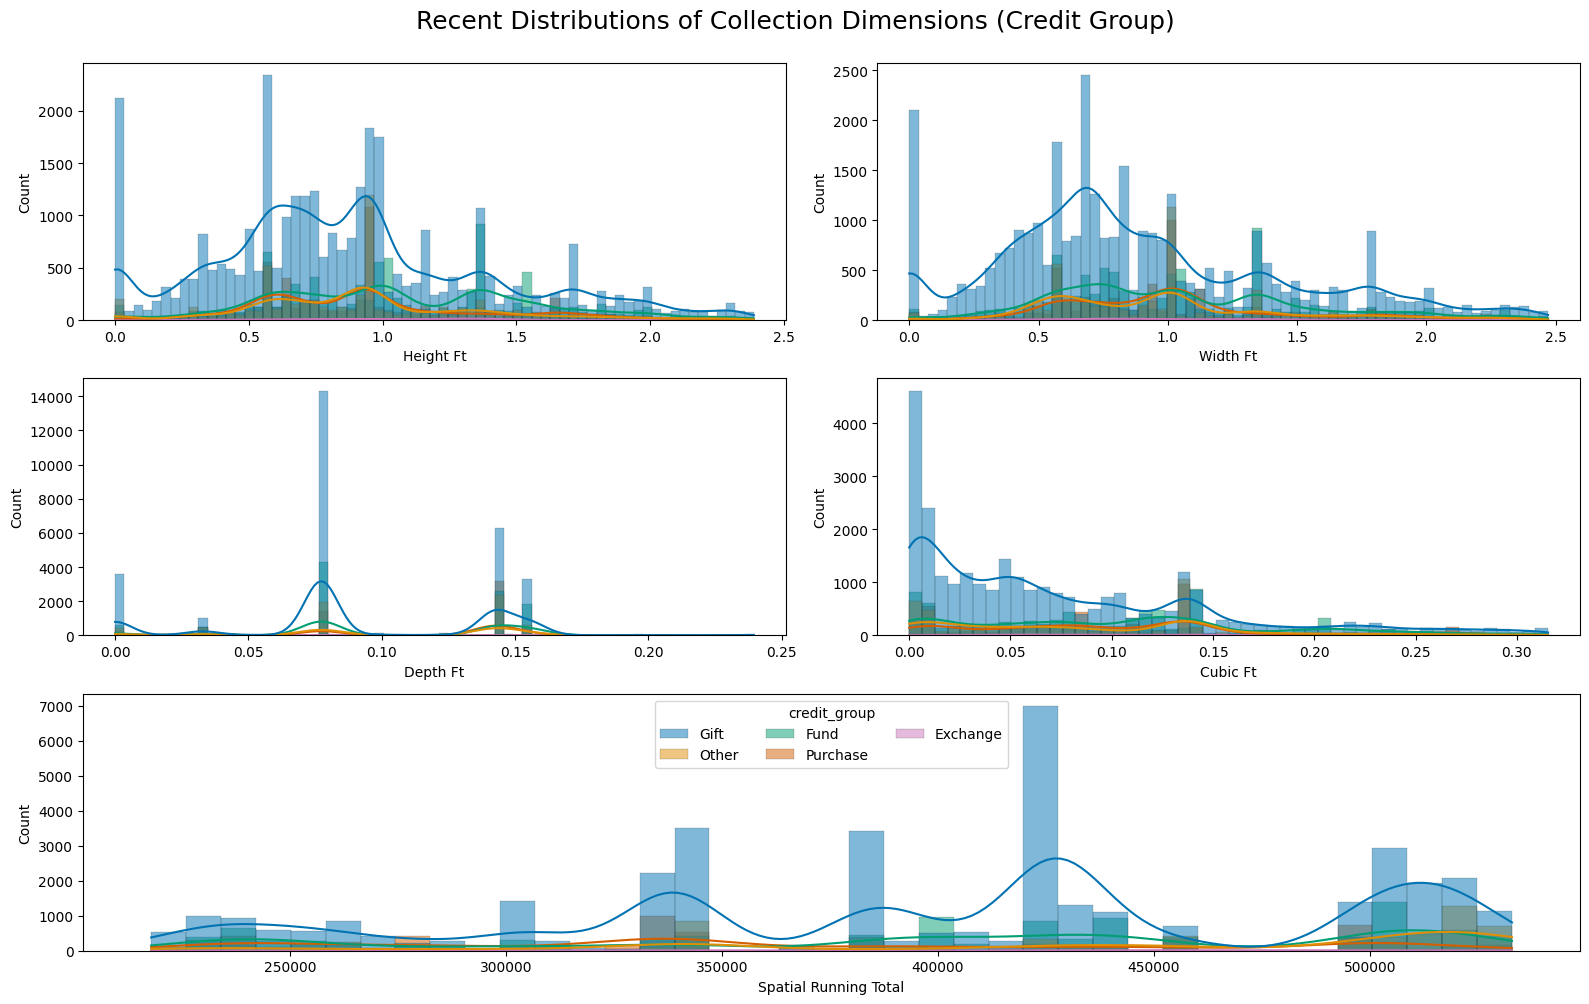

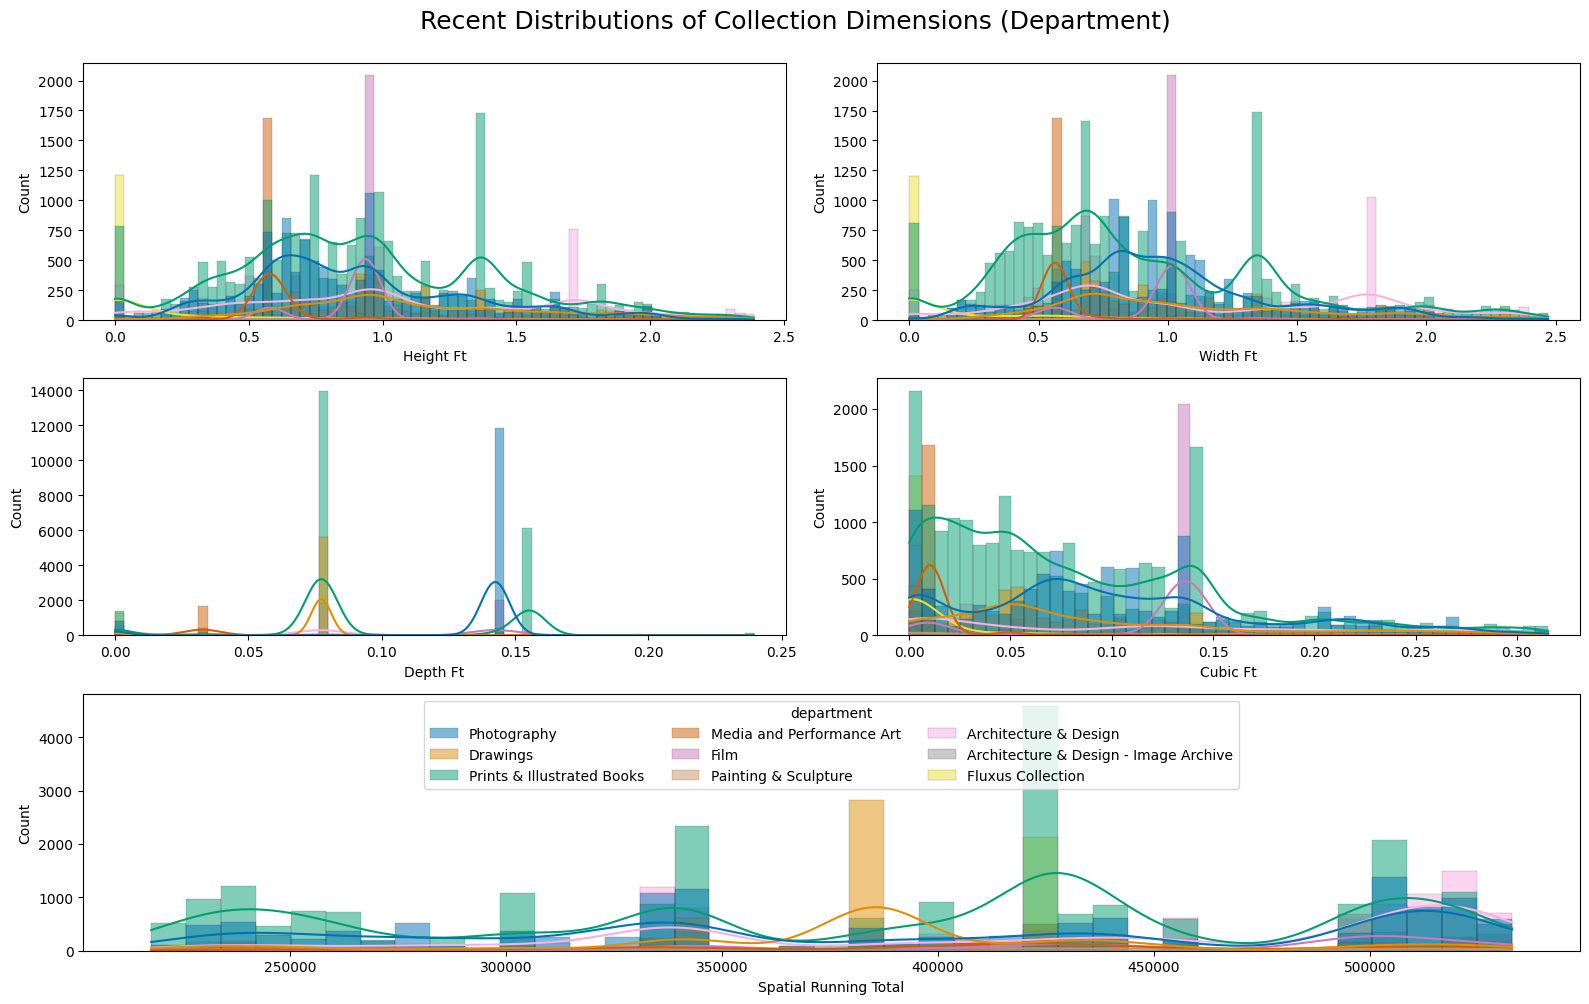

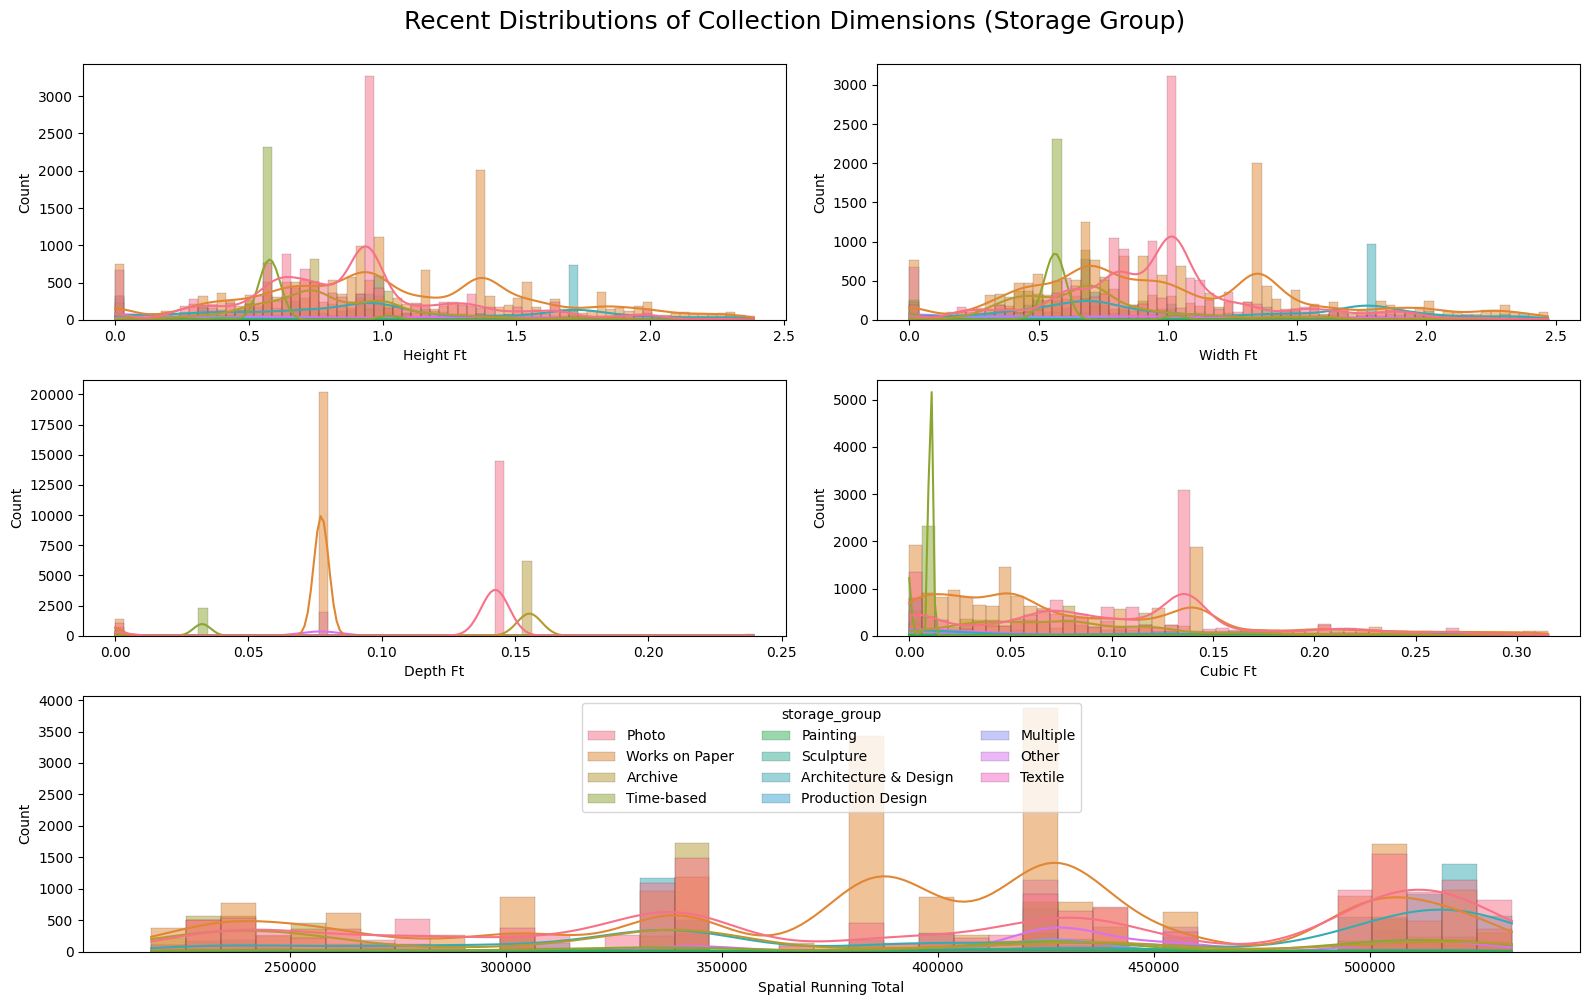

In [45]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Recent Distributions of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.histplot(data=datasets["recent_tsdata"], 
                     x = column, hue = category, linewidth = 0.1,
                     ax = ax, kde = True, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.histplot(data = datasets["recent_tsdata"], x = "spatial_running_total", hue = category, ax = combined_ax, kde = True, linewidth = 0.1)
    sns.move_legend(combined_ax, loc = "upper center", ncol = 3)
    combined_ax.set_xlabel("spatial running total".title())
    plt.tight_layout()
    plt.show()
    plt.close(fig)


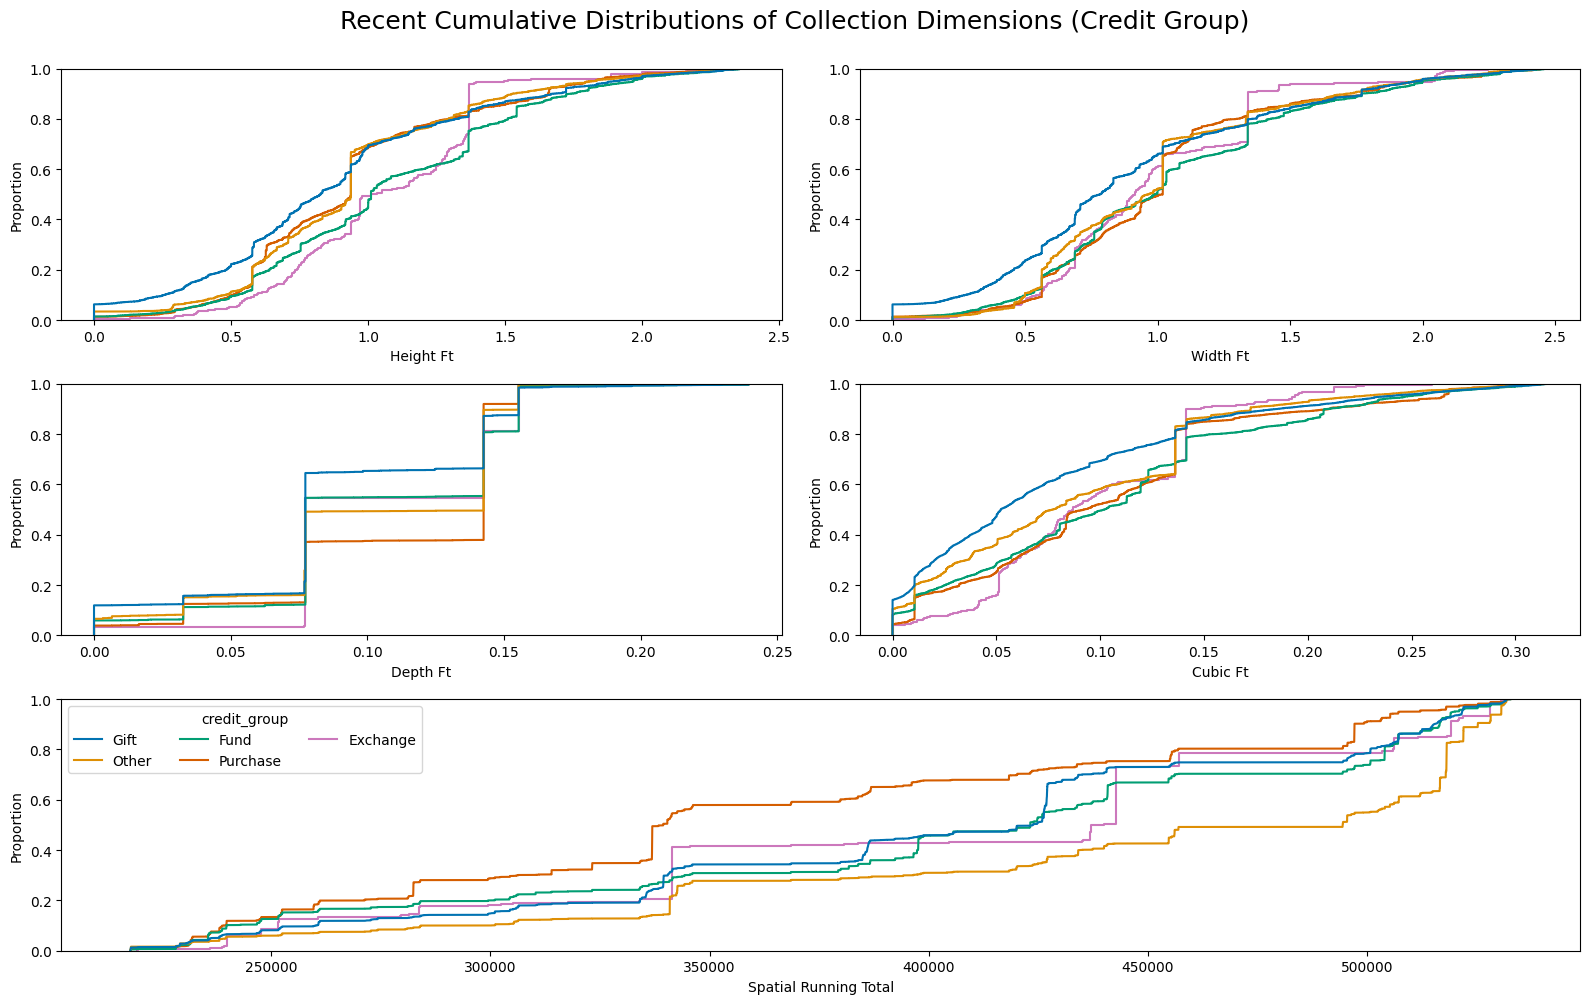

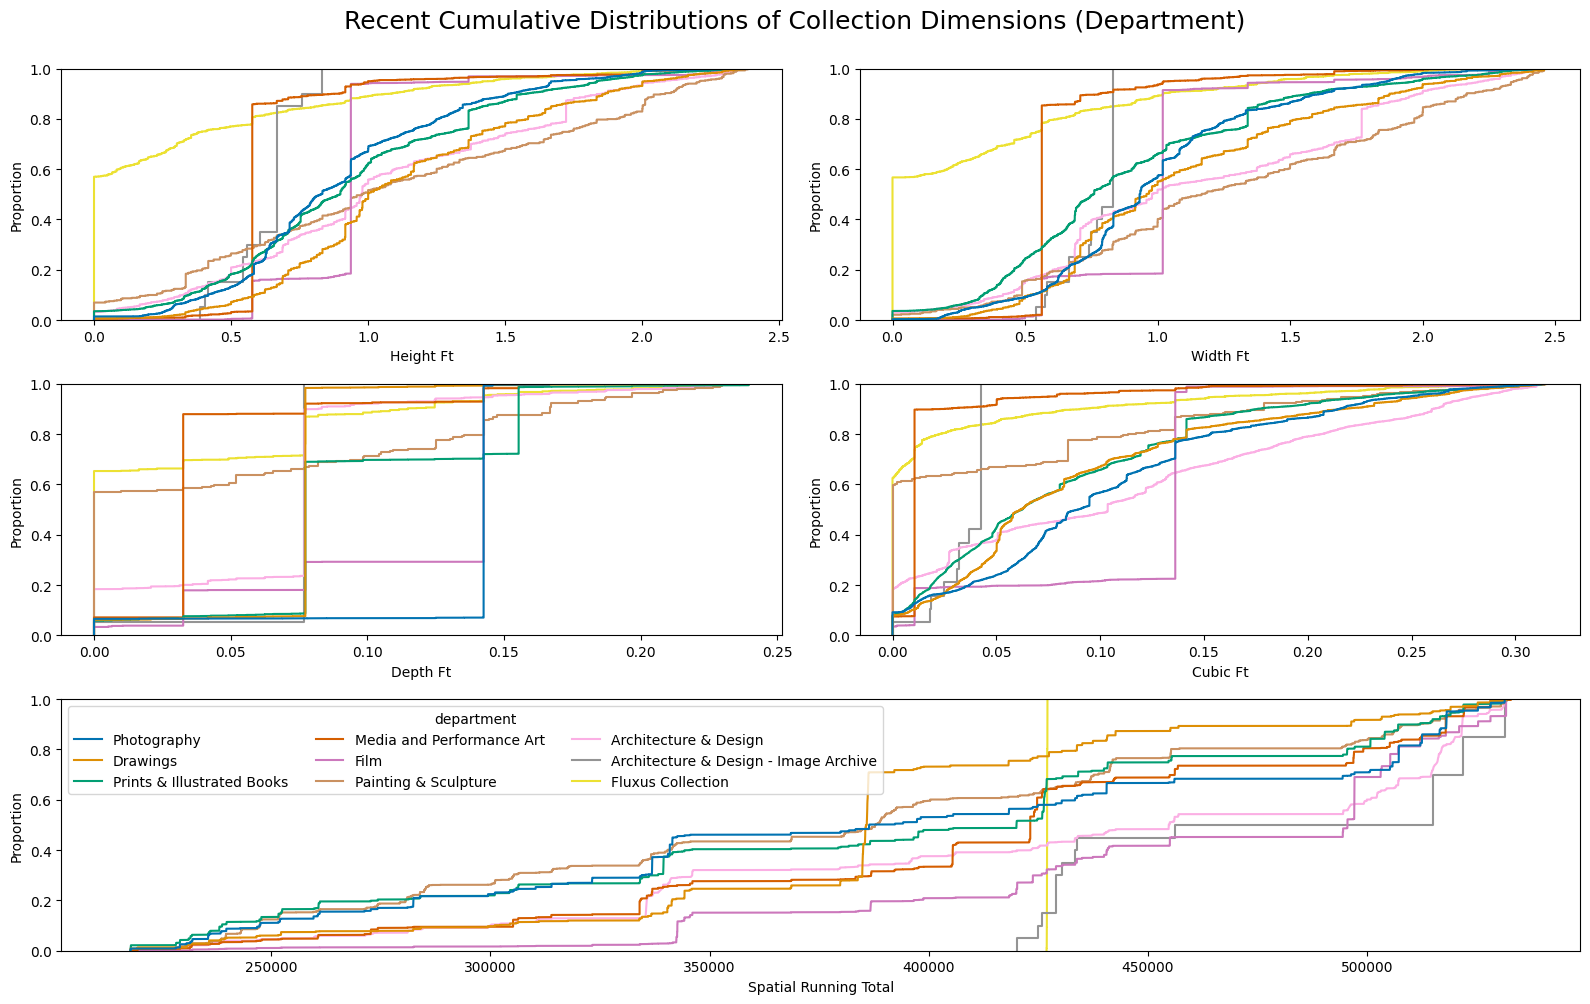

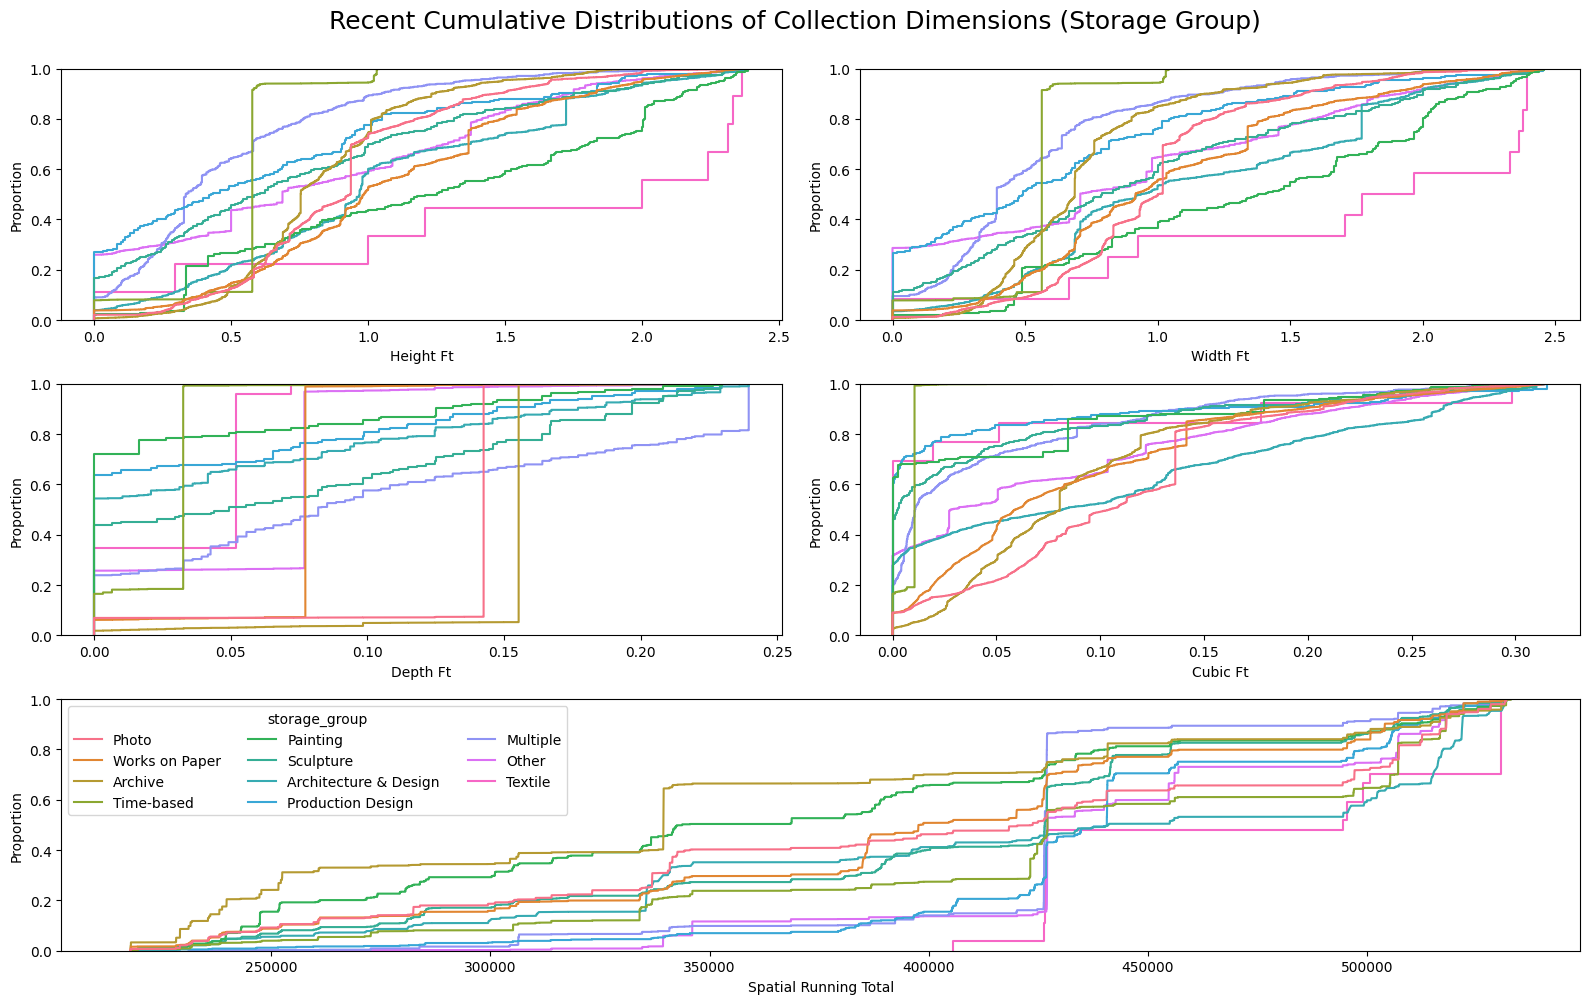

In [46]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Recent Cumulative Distributions of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.ecdfplot(data=datasets["recent_tsdata"], 
                     x = column, hue = category,
                     ax = ax, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.ecdfplot(data = datasets["recent_tsdata"], x = "spatial_running_total", hue = category, ax = combined_ax)
    combined_ax.set_xlabel("spatial running total".title())
    sns.move_legend(combined_ax, loc = "upper left", ncol = 3)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [47]:
(datasets["recent_tsdata"]
 .groupby("department")
 .describe()  # Descriptive Statistics Table by Department
 .T  # Transpose for a nice view
 )

department                      Architecture & Design  \
acquisition_date count                          10380   
                 mean   2008-01-03 09:09:46.820809216   
                 min              1987-05-27 00:00:00   
                 25%              2000-12-11 00:00:00   
                 50%              2011-03-07 00:00:00   
...                                               ...   
year             25%                         2000.000   
                 50%                         2011.000   
                 75%                         2014.000   
                 max                         2016.000   
                 std                            7.790   

department             Architecture & Design - Image Archive  \
acquisition_date count                                    20   
                 mean                    2012-05-16 22:48:00   
                 min                     2007-11-12 00:00:00   
                 25%                     2008-11-12 00:00:00   
                 50%                     2013-01-23 12:00:00   
...                                                      ...   
year             25%                                2008.000   
                 50%                                2012.500   
                 75%                                2015.000   
                 max                                2016.000   
                 std                                   3.420   

department                                   Drawings  \
acquisition_date count                           6269   
                 mean   2004-12-22 03:12:56.966023296   
                 min              1986-12-22 00:00:00   
                 25%              2003-12-09 00:00:00   
                 50%              2005-05-10 00:00:00   
...                                               ...   
year             25%                         2003.000   
                 50%                         2005.000   
                 75%                         2007.000   
                 max                         2016.000   
                 std                            6.012   

department                                       Film    Fluxus Collection  \
acquisition_date count                           2916                 2135   
                 mean   2010-04-06 18:51:21.481481472  2008-10-08 00:00:00   
                 min              1987-01-27 00:00:00  2008-10-08 00:00:00   
                 25%              2007-11-12 00:00:00  2008-10-08 00:00:00   
                 50%              2012-02-08 00:00:00  2008-10-08 00:00:00   
...                                               ...                  ...   
year             25%                         2007.000             2008.000   
                 50%                         2012.000             2008.000   
                 75%                         2013.000             2008.000   
                 max                         2016.000             2008.000   
                 std                            4.973                0.000   

department                  Media and Performance Art  \
acquisition_date count                           2348   
                 mean   2006-09-22 14:13:41.805792256   
                 min              1987-01-27 00:00:00   
                 25%              2000-12-09 00:00:00   
                 50%              2007-12-10 00:00:00   
...                                               ...   
year             25%                         2000.000   
                 50%                         2007.000   
                 75%                         2012.000   
                 max                         2016.000   
                 std                            7.021   

department                       Painting & Sculpture  \
acquisition_date count                           1519   
                 mean   2003-10-19 12:00:28.439762944   
                 min              1987-05-18 00:00:00   
           

In [48]:
(datasets["recent_tsdata"]
 .groupby("storage_group")
 .describe()  # Descriptive Statistics Table by Storage Group / Type
 .T  # Transpose for a nice view
 )

storage_group                   Architecture & Design  \
acquisition_date count                           8501   
                 mean   2007-06-29 08:20:43.336078336   
                 min              1987-05-27 00:00:00   
                 25%              2000-01-19 00:00:00   
                 50%              2010-12-06 00:00:00   
...                                               ...   
year             25%                         2000.000   
                 50%                         2010.000   
                 75%                         2014.000   
                 max                         2016.000   
                 std                            8.206   

storage_group                                 Archive  \
acquisition_date count                           6586   
                 mean   2000-11-17 15:51:06.504707072   
                 min              1987-01-15 00:00:00   
                 25%              1992-05-20 00:00:00   
                 50%              2001-01-24 00:00:00   
...                                               ...   
year             25%                         1992.000   
                 50%                         2001.000   
                 75%                         2008.750   
                 max                         2016.000   
                 std                            8.984   

storage_group                                Multiple  \
acquisition_date count                            975   
                 mean   2008-03-23 20:56:51.692307712   
                 min              1988-05-04 00:00:00   
                 25%              2008-10-08 00:00:00   
                 50%              2008-10-08 00:00:00   
...                                               ...   
year             25%                         2008.000   
                 50%                         2008.000   
                 75%                         2008.000   
                 max                         2016.000   
                 std                            3.785   

storage_group                                   Other  \
acquisition_date count                           2924   
                 mean   2009-10-24 06:00:29.548563456   
                 min              1991-07-09 00:00:00   
                 25%              2008-10-08 00:00:00   
                 50%              2008-10-08 00:00:00   
...                                               ...   
year             25%                         2008.000   
                 50%                         2008.000   
                 75%                         2012.000   
                 max                         2016.000   
                 std                            4.020   

storage_group                                Painting  \
acquisition_date count                            780   
                 mean   2002-08-10 21:19:23.076923136   
                 min              1987-05-18 00:00:00   
                 25%              1994-12-08 00:00:00   
                 50%              2002-10-07 00:00:00   
...                                               ...   
year             25%                         1994.000   
                 50%                         2002.000   
                 75%                         2008.000   
                 max                         2016.000   
                 std                            8.262   

storage_group                                   Photo  \
acquisition_date count                          15892   
                 mean   2005-09-11 01:53:59.365718528   
                 min              1986-12-18 00:00:00   
                 25%              1999-12-09 00:00:00   
                 50%              2008-02-14 00:00:00   
...                                               ...   
year             25%                         1999.000   
                 50%                         2008.000   
                 75%                         2013.000   
     

In [49]:
(datasets["recent_tsdata"]
 .groupby("credit_group")
 .describe()  # Descriptive Statistics Table by Credit Group
 .T  # Transpose for a nice view
 )

credit_group                                 Exchange  \
acquisition_date count                            353   
                 mean   2006-04-03 12:02:02.379603456   
                 min              1987-05-27 00:00:00   
                 25%              2001-12-13 00:00:00   
                 50%              2010-03-08 00:00:00   
...                                               ...   
year             25%                         2001.000   
                 50%                         2010.000   
                 75%                         2011.000   
                 max                         2016.000   
                 std                            8.188   

credit_group                                     Fund  \
acquisition_date count                          11142   
                 mean   2005-09-15 09:27:14.248788480   
                 min              1986-12-18 00:00:00   
                 25%              1999-06-10 00:00:00   
                 50%              2007-12-10 00:00:00   
...                                               ...   
year             25%                         1999.000   
                 50%                         2007.000   
                 75%                         2012.000   
                 max                         2016.000   
                 std                            8.496   

credit_group                                     Gift  \
acquisition_date count                          37652   
                 mean   2005-08-16 11:33:50.426006656   
                 min              1986-12-18 00:00:00   
                 25%              2000-12-11 00:00:00   
                 50%              2008-02-14 00:00:00   
...                                               ...   
year             25%                         2000.000   
                 50%                         2008.000   
                 75%                         2011.000   
                 max                         2016.000   
                 std                            7.677   

credit_group                                    Other  \
acquisition_date count                           6344   
                 mean   2008-11-20 02:33:40.176544768   
                 min              1986-12-18 00:00:00   
                 25%              2002-07-23 00:00:00   
                 50%              2011-10-03 00:00:00   
...                                               ...   
year             25%                         2002.000   
                 50%                         2011.000   
                 75%                         2015.000   
                 max                         2016.000   
                 std                            7.996   

credit_group                                 Purchase  
acquisition_date count                           6630  
                 mean   2002-04-28 08:30:24.434389120  
                 min              1986-12-18 00:00:00  
                 25%              1995-06-15 00:00:00  
                 50%              2000-12-12 00:00:00  
...                                               ...  
year             25%                         1995.000  
                 50%                         2000.000  
                 75%                         2010.000  
                 max                         2016.000  
                 std                            8.095  

[112 rows x 5 columns]

In [50]:
(datasets["recent_tsdata"].to_csv("NYC-MoMA-Recent-Collections_TS.csv"))

## Conclusions & Recommendations

I will add thinking for how to go about forecasting given our analysis. All of that will be added in this section, which doubles as a high-level overview of the forecasting approach.

Models in consideration:
Naive Forecast, MA, ES, CROSTON, SBA, TBS

Why:
Given that our professional working assumption is that our data as accession-only and accessions counts cannot go below zero, it's necessary to model the data as a "Intermittent Demand-side Forecasting" problem. Borrowing from the field of predictive inventory analytics, this approach allows us to model influxes of objects in a collection without necessitating deaccession data to make predictions about collections growth. In live projects with MMM clients, we anticipate having more flexibility in our model selection processes (because we're not actually working with the MoMA, just their data). As the stand-in for our collections professional client, Samantha, had put forward that they would like to understand any hierarchical relationships within the dataset such as object counts by department and storage group as they filter up to inform the overall total of incoming works.  

What:
For our forecasting process, we will be comparing a couple of standard statistical models to more specified predictive techniques. The client's desired analysis outcomes indicate to me that we will be prioritizing bottom-up hierarchical models which have been designed to perform well in predicting intermittent, incoming quantities. Each of the statistical models have accompanying metrics which describe various aspects of their predictive performance, for the purposes of this demonstration analysis we will be using the following metrics: MSE, RMSE, MAD, etc.